# Week HW 26

# Import


In [1]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [2]:
import numpy as np
from datetime import datetime

#####################

salvage_value = 0
cost = 300
price = 1000
holding_cost = 0

model_prefix = f"med_with_holding_cost_{holding_cost}"

#####################

CHUNK_SIZE = 20
data_size = CHUNK_SIZE * 3
train_size = 0.5
testing_size = 0.5

T = 10
service_level = 0.95  # 服務水準
M = 5000000
LASSO_BETA = 100

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 20000
MIPGAP = 0.01
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [3]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [5]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [6]:
show_models("linear_constraint_med_with_holding_cost")

In [7]:
show_models("med_with_holding_cost")

Contents of models/med_with_holding_cost_0_s2_150_202503242219.pkl:
{'alpha': array([-0.86625191, -0.23051394,  3.32199823, -0.73987358,  2.20504008])}



## Visualization 

In [8]:
def plot_strategies_profits_scatter(save_type, dfs: dict):
    names = list(dfs.keys())
    df_list = [dfs[name] for name in names]

    if len(df_list) <= 1:
        print("No dataframes to plot.")
        return

    pairs = list(itertools.combinations(range(len(df_list)), 2))
    num_pairs = len(pairs)
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)
        df_i, df_j = df_list[i], df_list[j]

        if df_i is None or df_j is None or df_i.empty or df_j.empty:
            continue
        if len(df_i) != len(df_j):
            continue

        ax = axes[row, col]
        ax.scatter(df_i["profits"], df_j["profits"], alpha=0.6)
        ax.plot(
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            "k--",
            linewidth=1,
        )
        ax.set_xlabel(names[i])
        ax.set_ylabel(names[j])
        ax.set_title(f"{names[i]} vs {names[j]}")

    # Remove empty subplots
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/plot_strategies_profits_scatter_{save_type}.png"
    plt.savefig(save_path, bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    plt.show()
    plt.close()

In [9]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            if baseline_profit != 0:
                ratio = (max_profit - baseline_profit) / abs(baseline_profit)
                ratios[f"S{idx}"] = ratio
            else:
                # 基準利潤為零時，直接記錄增量
                ratio = max_profit
                ratios[f"S{idx}"] = ratio

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [10]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            if test_baseline_profit != 0:
                test_ratio = (test_profit - test_baseline_profit) / abs(
                    test_baseline_profit
                )  # Relative deviation
            else:
                test_ratio = test_profit  # Use profit directly if baseline is zero
            test_ratios[f"S{idx}"] = test_ratio

        if train_profit is not None and train_profit != -1:
            if train_baseline_profit != 0:
                train_ratio = (train_profit - train_baseline_profit) / abs(
                    train_baseline_profit
                )  # Relative deviation
            else:
                train_ratio = train_profit  # Use profit directly if baseline is zero
            train_ratios[f"S{idx}"] = train_ratio

    # Define the fixed range of the y-axis
    max_value = max(
        max(test_ratios.values(), default=0), max(train_ratios.values(), default=0)
    )
    y_max = min(max_value + 0.1, 1.0)  # Limit max y to 1.0
    y_min = -y_max  # Keep symmetric scaling

    # Ensure y-axis tick marks are at intervals of 0.05
    y_ticks = np.arange(y_min, y_max + 0.05, 0.05)  # Generate ticks

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())

    # Set fixed y-axis range and ticks
    plt.ylim(y_min, y_max)
    plt.yticks(y_ticks)  # Apply fixed 0.05 intervals

    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [11]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [12]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [13]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [14]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [15]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [16]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    gamma_values=None
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
        "gamma_values": [gamma_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [17]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(10, 15, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
        # "X3": np.random.uniform(1000, 2000, data_size),
        "X3": np.random.uniform(50, 300, data_size),
        # "X3": np.random.uniform(50, 150, data_size),
        # "X3": np.random.uniform(50, 60, data_size),
        "X4": np.random.uniform(5, 15, data_size),
    }
)

full_df

,X1,X2,X3,X4
0,12.744068,-26.820608,231.313570,6.646942
1,13.575947,-27.792497,175.331095,11.214784
2,13.013817,-16.873408,289.020909,10.772286
3,12.724416,-27.236341,210.997550,7.378928
4,12.118274,-26.068353,155.963762,14.342140
5,13.229471,-22.625497,201.598304,11.139660
6,12.187936,-13.580135,54.798300,10.356328
7,14.458865,-28.057974,125.393704,10.899100
8,14.818314,-13.241102,215.043384,12.301220
9,11.917208,-28.078032,122.519402,8.119450


In [18]:
features_num = full_df.shape[1]
features_num

4

### Split training and testing data


In [19]:
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalized(data, train_size=0.5):
    folds = []
    scalers = []

    # 計算訓練集的大小
    train_len = int(len(data) * train_size)

    # 將資料切分為前半部分為訓練集，後半部分為測試集
    train_data = data.iloc[:train_len].reset_index(drop=True)
    test_data = data.iloc[train_len:].reset_index(drop=True)

    # 標準化處理
    scaler = StandardScaler()
    train_data_normalized = scaler.fit_transform(train_data)
    test_data_normalized = scaler.transform(test_data)

    # 將標準化資料轉回 DataFrame
    train_data_normalized = pd.DataFrame(train_data_normalized, columns=data.columns)
    test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

    # 將資料加入 folds 與 scaler
    folds.append((train_data_normalized, test_data_normalized))
    scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalized(full_df, train_size)

for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (30, 4), Test size: (30, 4)
Train (normalized):
         X1        X2        X3        X4
0 -0.115310 -0.868850  0.645575 -1.101655
1  0.478521 -1.031688 -0.250016  0.665497
2  0.077249  0.797778  1.568759  0.494308
3 -0.129338 -0.938505  0.320565 -0.818473
4 -0.562028 -0.742812 -0.559849  1.875370
Test (normalized):
         X1        X2        X3        X4
0 -1.129886 -0.334041 -1.657318  2.092500
1  0.689262  0.834909  1.216980 -0.899699
2 -0.446044 -0.959901 -1.605147  0.826433
3 -0.045280  0.998827  0.206859 -0.720094
4 -2.007076 -0.431764 -1.759817 -1.658912



In [20]:
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalized_k_fold(data, train_size=0.5, chunk_size=CHUNK_SIZE):

    folds = []
    scalers = []
    train_chunk = int(train_size * chunk_size)
    n = len(data)

    # 依序將資料切分成 chunk_size 大小的子集
    for start in range(0, n, chunk_size):
        if start + chunk_size > n:
            break  # 若剩餘資料不足一個完整的 chunk，則跳過
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)

        # 建立並使用 StandardScaler 分別標準化當前的訓練與測試資料
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # 轉回 DataFrame 格式
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalized_k_fold(full_df)

for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.shape)
    print(train.head())
    print("Test (normalized):")
    print(test.shape)
    print(test.head())
    print()

Fold 1:
Train size: (10, 4), Test size: (10, 4)
Train (normalized):
(10, 4)
         X1        X2        X3        X4
0 -0.362937 -0.650803  0.842972 -1.656309
1  0.538952 -0.817990 -0.045499  0.405126
2 -0.070486  1.060352  1.758819  0.205430
3 -0.384243 -0.722318  0.520546 -1.325969
4 -1.041396 -0.521397 -0.352869  1.816480
Test (normalized):
(10, 4)
         X1        X2        X3        X4
0  0.953836  2.161751  0.417488 -0.602419
1 -0.470912  0.414649 -0.333374 -1.452552
2 -0.258690  2.162788 -1.497059 -1.559286
3  1.679526  0.883222 -0.851096  1.862324
4 -2.952869  1.345684  0.226841  0.937978

Fold 2:
Train size: (10, 4), Test size: (10, 4)
Train (normalized):
(10, 4)
         X1        X2        X3        X4
0  1.380816 -0.495010  0.772008 -0.407182
1  0.758774 -0.117795 -1.144651  1.008808
2 -0.411686 -1.489514 -0.897170 -0.164317
3  0.694201  0.972202  0.755256 -0.893943
4 -1.601301  0.479053  0.444635 -1.464411
Test (normalized):
(10, 4)
         X1        X2        X3      

## Data2: demand_df


### mu of each time(t)


In [21]:
# 設定 b0, b1, b2

# b0 = 0
# b1 = 1
# b2 = 2
# b3 = -1
# b4 = 2
# bt = 0

b0 = 0
b1 = 0
b2 = 0
b3 = 1
b4 = 0
bt = 0

# b0 = 0
# b1 = 1
# b2 = 1


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b0 * random_noises[t - 1]
            + b1 * training_df["X1"]
            + b2 * training_df["X2"]
            + b3 * training_df["X3"]
            + b4 * training_df["X4"]
            + bt * t
        )

    return mu_matrix

In [22]:
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[:3]}")

mu_matrix shape: (60, 10)
mu_matrix[0]: 
[[231.31356995 231.31356995 231.31356995 231.31356995 231.31356995
  231.31356995 231.31356995 231.31356995 231.31356995 231.31356995]
 [175.33109548 175.33109548 175.33109548 175.33109548 175.33109548
  175.33109548 175.33109548 175.33109548 175.33109548 175.33109548]
 [289.02090868 289.02090868 289.02090868 289.02090868 289.02090868
  289.02090868 289.02090868 289.02090868 289.02090868 289.02090868]]


### sigma matrix


In [23]:
X = full_df.values
feature_num = X.shape[1]
print(f"X.shape: {X.shape}")

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

X.shape: (60, 4)
coefficients.shape: (4, 10)
coefficients: [[ 0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823 -0.12482558
   0.783546    0.92732552 -0.23311696  0.58345008]
 [ 0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321
   0.66523969  0.5563135   0.7400243   0.95723668]
 [ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]
 [ 0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099  0.22419145
   0.23386799  0.88749616  0.3636406  -0.2809842 ]]


In [24]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
# print(f"sigma_matrix.shape: {sigma_matrix.shape}")
# print(f"sigma_matrix: {sigma_matrix}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到 [2, 10] 的範圍
# shape: (data_size, T)
# sigma_matrix = 0 + sigma_matrix * 300

# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
sigma_matrix = 0 + sigma_matrix * 100
# sigma_matrix = 50 + sigma_matrix * 50
# sigma_matrix = 0 + sigma_matrix * 10

# sigma_matrix = 0 + sigma_matrix * 80
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

Value range: (np.float64(3.017227072932997e-102), np.float64(1.0))
New Value range: (np.float64(3.017227072932997e-100), np.float64(100.0))


((60, 10),
 array([[1.00000000e+002, 6.28212482e-007, 1.00000000e+002,
         8.18942196e-069, 1.00000000e+002, 5.19411530e-059,
         1.00000000e+002, 9.99998563e+001, 1.70686949e-024,
         1.59167410e-054],
        [1.00000000e+002, 3.26615093e-005, 1.00000000e+002,
         7.45874343e-052, 1.00000000e+002, 7.28447791e-041,
         1.00000000e+002, 9.99999771e+001, 5.08908762e-020,
         7.94064998e-044],
        [1.00000000e+002, 2.09971763e-008, 1.00000000e+002,
         2.14398774e-093, 1.00000000e+002, 1.20415253e-080,
         1.00000000e+002, 1.00000000e+002, 5.96799306e-025,
         1.26084558e-062],
        [1.00000000e+002, 2.65245307e-006, 1.00000000e+002,
         3.15890969e-062, 1.00000000e+002, 1.79713580e-052,
         1.00000000e+002, 9.99997660e+001, 5.27323650e-023,
         1.22867320e-050],
        [1.00000000e+002, 1.03447077e-004, 1.00000000e+002,
         2.76219121e-047, 1.00000000e+002, 3.36518359e-035,
         1.00000000e+002, 9.99999951e+001

### corr matrix


In [25]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [26]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (60, 10, 10)
cov_matrices: 
[[ 1.00000000e+004  2.22539743e-005  5.55783601e+003  4.81055363e-067
  -3.87773693e+003 -8.38767926e-058 -9.90728021e+002 -2.75943264e+003
  -8.34473596e-023 -3.33052950e-054]
 [ 2.22539743e-005  3.94650922e-013  4.05618796e-005  1.77105591e-075
  -3.35441773e-005 -3.87365968e-066 -2.30303263e-005  4.53758154e-006
   1.17905581e-031 -4.91218859e-062]
 [ 5.55783601e+003  4.05618796e-005  1.00000000e+004  2.12702218e-067
  -4.28491664e+003 -1.22851441e-057 -5.51543207e+003  1.05625309e+002
  -7.07064027e-023 -2.04862335e-053]
 [ 4.81055363e-067  1.77105591e-075  2.12702218e-067  6.70666321e-137
  -3.55187970e-067 -3.35877280e-128  1.36134952e-067 -5.16769437e-067
   1.24601150e-093  3.18281885e-123]
 [-3.87773693e+003 -3.35441773e-005 -4.28491664e+003 -3.55187970e-067
   1.00000000e+004  1.92908945e-057  3.00310341e+003  2.94019265e+003
  -2.62378761e-023 -1.72773947e-053]
 [-8.38767926e-058 -3.87365968e-066 -1.22851441e-057 -3.35877280e-1

In [27]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: False


### MVN stimulation for demand_df


In [28]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,145.898688,231.313569,10.815686,231.313570,470.226719,231.313570,222.360630,176.632109,231.313570,231.313570
1,176.859937,175.331068,81.371862,175.331096,149.963831,175.331095,210.118668,36.374459,175.331095,175.331095
2,485.596120,289.020909,376.336644,289.020908,20.311809,289.020909,93.564299,162.517296,289.020909,289.020909
3,216.299539,210.997551,192.586949,210.997549,107.939667,210.997550,336.798423,275.789853,210.997550,210.997550
4,308.357633,155.963872,369.380315,155.963762,259.789273,155.963762,70.742527,237.435759,155.963762,155.963762
5,283.965993,201.598308,261.057169,201.598304,63.433728,201.598304,220.060138,194.832572,201.598304,201.598304
6,111.943975,57.219686,115.788421,54.798299,-81.380052,54.798300,71.039367,145.029934,54.798301,54.798300
7,0.983628,125.393913,8.661834,125.393704,78.582722,125.393704,138.236747,135.491773,125.393704,125.393704
8,307.613840,215.043375,203.109888,215.043384,3.256296,215.043384,171.405372,146.934364,215.043384,215.043384
9,200.738054,122.517963,106.712210,122.519402,124.600960,122.519402,122.450775,-20.837717,122.519402,122.519402


### Replace negative values to 0


In [29]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,145.898688,231.313569,10.815686,231.313570,470.226719,231.313570,222.360630,176.632109,231.313570,231.313570
1,176.859937,175.331068,81.371862,175.331096,149.963831,175.331095,210.118668,36.374459,175.331095,175.331095
2,485.596120,289.020909,376.336644,289.020908,20.311809,289.020909,93.564299,162.517296,289.020909,289.020909
3,216.299539,210.997551,192.586949,210.997549,107.939667,210.997550,336.798423,275.789853,210.997550,210.997550
4,308.357633,155.963872,369.380315,155.963762,259.789273,155.963762,70.742527,237.435759,155.963762,155.963762
5,283.965993,201.598308,261.057169,201.598304,63.433728,201.598304,220.060138,194.832572,201.598304,201.598304
6,111.943975,57.219686,115.788421,54.798299,0.000000,54.798300,71.039367,145.029934,54.798301,54.798300
7,0.983628,125.393913,8.661834,125.393704,78.582722,125.393704,138.236747,135.491773,125.393704,125.393704
8,307.613840,215.043375,203.109888,215.043384,3.256296,215.043384,171.405372,146.934364,215.043384,215.043384
9,200.738054,122.517963,106.712210,122.519402,124.600960,122.519402,122.450775,0.000000,122.519402,122.519402


### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [30]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

,theoretical_mean,empirical_mean,theoretical_std,empirical_std,std_relative_error
0,2313.135700,2182.501681,197.827753,106.938396,84.992258
1,1753.310955,1531.344208,197.827821,50.066327,295.131482
2,2890.209087,2583.430711,197.827831,127.775422,54.824635
3,2109.975498,2184.402180,197.827704,55.188729,258.456715
4,1559.637621,2025.524427,197.827837,84.702743,133.555407
5,2015.983035,2031.341121,197.827831,54.563972,262.561272
6,547.982996,720.214583,198.005254,39.285224,404.019667
7,1253.937042,988.925434,197.827914,49.537122,299.352864
8,2150.433844,1907.536672,197.827832,73.626544,168.690911
9,1225.194018,1167.097568,197.817426,45.875752,331.202576


### Validate normal distribution


In [31]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,145.898688,231.313569,10.815686,231.313570,470.226719,231.313570,222.360630,176.632109,231.313570,231.313570
1,176.859937,175.331068,81.371862,175.331096,149.963831,175.331095,210.118668,36.374459,175.331095,175.331095
2,485.596120,289.020909,376.336644,289.020908,20.311809,289.020909,93.564299,162.517296,289.020909,289.020909
3,216.299539,210.997551,192.586949,210.997549,107.939667,210.997550,336.798423,275.789853,210.997550,210.997550
4,308.357633,155.963872,369.380315,155.963762,259.789273,155.963762,70.742527,237.435759,155.963762,155.963762
5,283.965993,201.598308,261.057169,201.598304,63.433728,201.598304,220.060138,194.832572,201.598304,201.598304
6,111.943975,57.219686,115.788421,54.798299,0.000000,54.798300,71.039367,145.029934,54.798301,54.798300
7,0.983628,125.393913,8.661834,125.393704,78.582722,125.393704,138.236747,135.491773,125.393704,125.393704
8,307.613840,215.043375,203.109888,215.043384,3.256296,215.043384,171.405372,146.934364,215.043384,215.043384
9,200.738054,122.517963,106.712210,122.519402,124.600960,122.519402,122.450775,0.000000,122.519402,122.519402


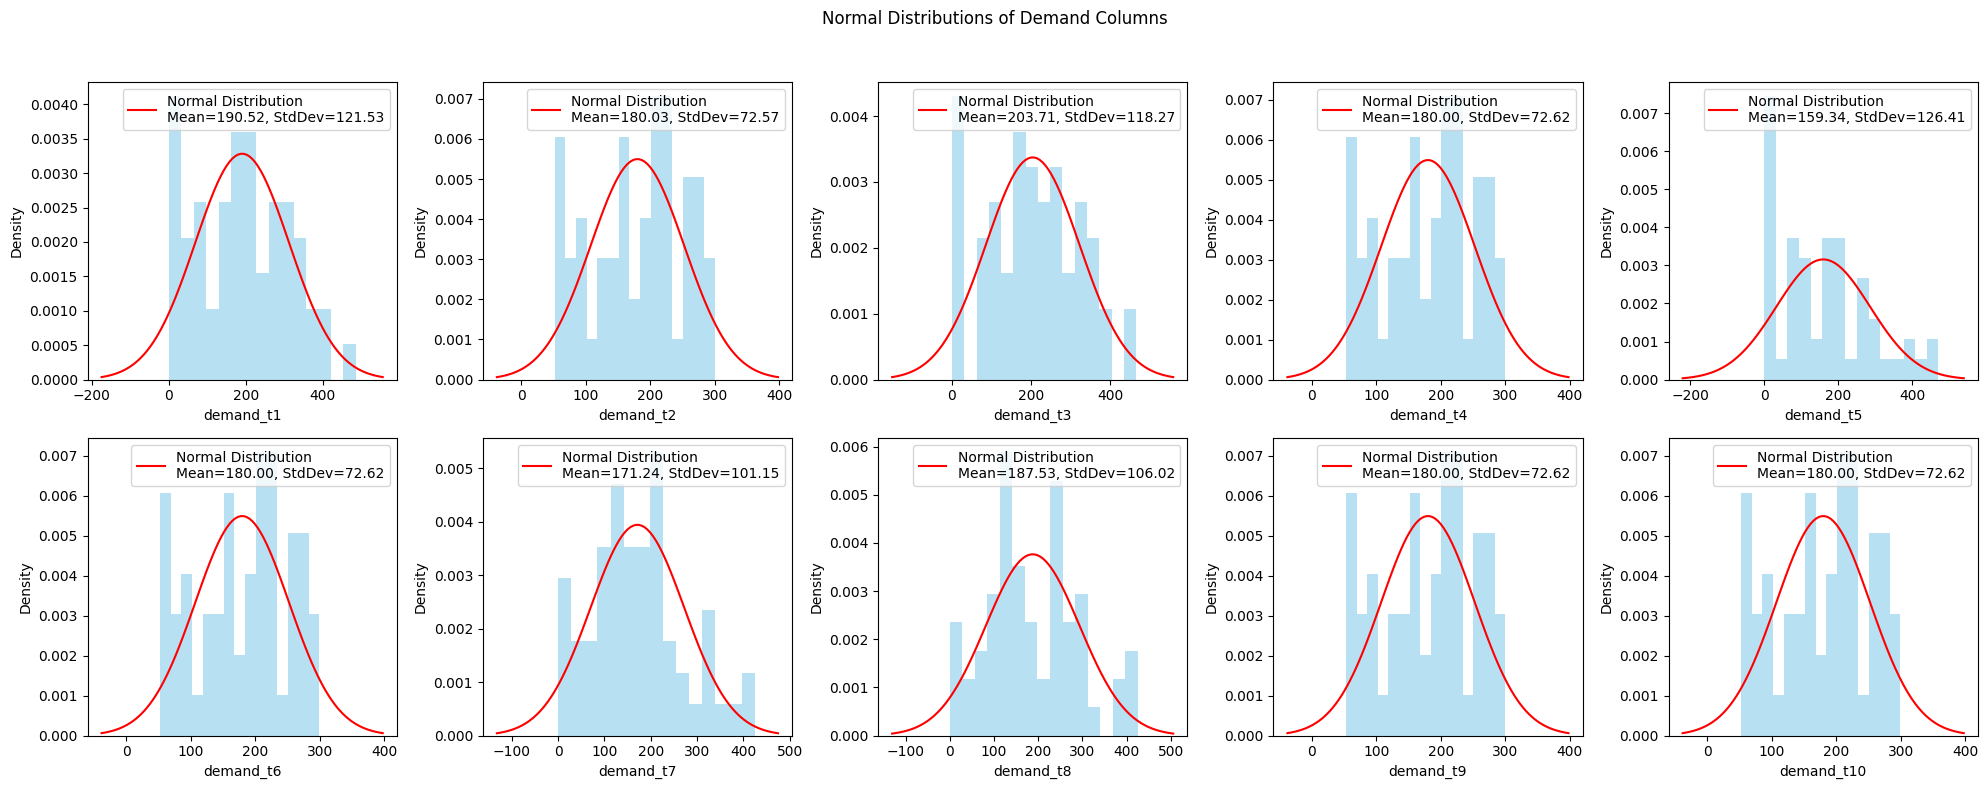

In [32]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [33]:
demand_df.cov()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,15019.876619,4577.466628,9296.470964,4578.139982,-185.141871,4578.140009,1147.502915,803.204566,4578.139985,4578.139987
demand_t2,4577.466628,5355.575986,5271.267907,5359.474866,5648.802146,5359.474938,2857.767956,4956.692494,5359.474870,5359.474873
demand_t3,9296.470964,5271.267907,14225.136715,5270.767417,1909.684206,5270.767394,-2460.394610,5556.826787,5270.767426,5270.767429
demand_t4,4578.139982,5359.474866,5270.767417,5363.505438,5655.082363,5363.505510,2863.115685,4959.118188,5363.505441,5363.505445
demand_t5,-185.141871,5648.802146,1909.684206,5655.082363,16251.009585,5655.082451,5614.935361,7902.896158,5655.082364,5655.082368
demand_t6,4578.140009,5359.474938,5270.767394,5363.505510,5655.082451,5363.505582,2863.115786,4959.118303,5363.505513,5363.505516
demand_t7,1147.502915,2857.767956,-2460.394610,2863.115685,5614.935361,2863.115786,10404.515164,3097.051938,2863.115686,2863.115688
demand_t8,803.204566,4956.692494,5556.826787,4959.118188,7902.896158,4959.118303,3097.051938,11431.094193,4959.118196,4959.118197
demand_t9,4578.139985,5359.474870,5270.767426,5363.505441,5655.082364,5363.505513,2863.115686,4959.118196,5363.505445,5363.505448
demand_t10,4578.139987,5359.474873,5270.767429,5363.505445,5655.082368,5363.505516,2863.115688,4959.118197,5363.505448,5363.505451


In [34]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,5019.876619,4573.573760,3738.635355,4578.139982,3692.595058,4578.140015,2138.230936,3561.314354,4578.139986,4578.139987
demand_t2,4573.573760,5355.447011,5264.172454,5359.474866,5654.670000,5359.474938,2861.796631,4955.900000,5359.474870,5359.474873
demand_t3,3738.635355,5264.172454,4225.138154,5270.767417,6194.600534,5270.767403,3055.037062,5451.252122,5270.767428,5270.767429
demand_t4,4578.139982,5359.474866,5270.767417,5363.505438,5655.082363,5363.505510,2863.115685,4959.118188,5363.505441,5363.505445
demand_t5,3692.595058,5654.670000,6194.600534,5655.082363,6251.009585,5655.082437,2611.831955,4964.113019,5655.082364,5655.082368
demand_t6,4578.140015,5359.474938,5270.767403,5363.505510,5655.082437,5363.505582,2863.115761,4959.118284,5363.505513,5363.505516
demand_t7,2138.230936,2861.796631,3055.037062,2863.115685,2611.831955,2863.115761,404.515164,2707.825407,2863.115686,2863.115688
demand_t8,3561.314354,4955.900000,5451.252122,4959.118188,4964.113019,4959.118284,2707.825407,1440.636753,4959.118197,4959.118197
demand_t9,4578.139986,5359.474870,5270.767428,5363.505441,5655.082364,5363.505513,2863.115686,4959.118197,5363.505445,5363.505448
demand_t10,4578.139987,5359.474873,5270.767429,5363.505445,5655.082368,5363.505516,2863.115688,4959.118197,5363.505448,5363.505451


### Validate the corr matrix of damand_df is close to original setting


In [35]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,145.898688,231.313569,10.815686,231.313570,470.226719,231.313570,222.360630,176.632109,231.313570,231.313570
1,176.859937,175.331068,81.371862,175.331096,149.963831,175.331095,210.118668,36.374459,175.331095,175.331095
2,485.596120,289.020909,376.336644,289.020908,20.311809,289.020909,93.564299,162.517296,289.020909,289.020909
3,216.299539,210.997551,192.586949,210.997549,107.939667,210.997550,336.798423,275.789853,210.997550,210.997550
4,308.357633,155.963872,369.380315,155.963762,259.789273,155.963762,70.742527,237.435759,155.963762,155.963762
5,283.965993,201.598308,261.057169,201.598304,63.433728,201.598304,220.060138,194.832572,201.598304,201.598304
6,111.943975,57.219686,115.788421,54.798299,0.000000,54.798300,71.039367,145.029934,54.798301,54.798300
7,0.983628,125.393913,8.661834,125.393704,78.582722,125.393704,138.236747,135.491773,125.393704,125.393704
8,307.613840,215.043375,203.109888,215.043384,3.256296,215.043384,171.405372,146.934364,215.043384,215.043384
9,200.738054,122.517963,106.712210,122.519402,124.600960,122.519402,122.450775,0.000000,122.519402,122.519402


In [36]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,1.000000,0.510374,0.635999,0.510072,-0.011850,0.510072,0.091793,0.061298,0.510072,0.510072
demand_t2,0.510374,1.000000,0.603926,0.999988,0.605499,0.999988,0.382836,0.633498,0.999988,0.999988
demand_t3,0.635999,0.603926,1.000000,0.603422,0.125601,0.603422,-0.202239,0.435767,0.603422,0.603422
demand_t4,0.510072,0.999988,0.603422,1.000000,0.605723,1.000000,0.383269,0.633339,1.000000,1.000000
demand_t5,-0.011850,0.605499,0.125601,0.605723,1.000000,0.605723,0.431811,0.579832,0.605723,0.605723
demand_t6,0.510072,0.999988,0.603422,1.000000,0.605723,1.000000,0.383269,0.633339,1.000000,1.000000
demand_t7,0.091793,0.382836,-0.202239,0.383269,0.431811,0.383269,1.000000,0.283984,0.383269,0.383269
demand_t8,0.061298,0.633498,0.435767,0.633339,0.579832,0.633339,0.283984,1.000000,0.633339,0.633339
demand_t9,0.510072,0.999988,0.603422,1.000000,0.605723,1.000000,0.383269,0.633339,1.000000,1.000000
demand_t10,0.510072,0.999988,0.603422,1.000000,0.605723,1.000000,0.383269,0.633339,1.000000,1.000000


In [37]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.354243,0.555784,0.587411,-0.387774,-0.161484,-0.099073,-0.275944,-0.488891,-0.020925
1,0.354243,1.000000,0.645671,0.344249,-0.533962,-0.118714,-0.366601,0.072230,0.109958,-0.049126
2,0.555784,0.645671,1.000000,0.259728,-0.428492,-0.236520,-0.551543,0.010563,-0.414246,-0.128709
3,0.587411,0.344249,0.259728,1.000000,-0.433716,-0.078962,0.166233,-0.631022,0.089139,0.244177
4,-0.387774,-0.533962,-0.428492,-0.433716,1.000000,0.371399,0.300310,0.294020,-0.153719,-0.108549
5,-0.161484,-0.118714,-0.236520,-0.078962,0.371399,1.000000,0.658292,0.520508,-0.341738,0.147419
6,-0.099073,-0.366601,-0.551543,0.166233,0.300310,0.658292,1.000000,0.038941,-0.009772,0.485870
7,-0.275944,0.072230,0.010563,-0.631022,0.294020,0.520508,0.038941,1.000000,-0.203659,0.130487
8,-0.488891,0.109958,-0.414246,0.089139,-0.153719,-0.341738,-0.009772,-0.203659,1.000000,0.355112
9,-0.020925,-0.049126,-0.128709,0.244177,-0.108549,0.147419,0.485870,0.130487,0.355112,1.000000


### Split test and train demand_df


In [38]:
def demand_data_split_data_k_fold(data):
    folds = []
    chunk_size = CHUNK_SIZE  # 每組 60 筆資料
    train_chunk = int(train_size * chunk_size)

    n = len(data)
    # 依序切分每一個 chunk
    for start in range(0, n, chunk_size):
        # 若剩餘資料不足 60 筆，這裡直接跳過
        if start + chunk_size > n:
            break
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)
        folds.append((train_data, test_data))

    return folds


# 使用函數切分資料
demand_folds = demand_data_split_data_k_fold(demand_df)

# 印出結果，每個 fold 的訓練與測試資料
for i, (train_data, test_data) in enumerate(demand_folds, 1):
    print(f"Fold {i}:")
    print("Train Data:")
    print(train_data.shape)
    print("Test Data:")
    print(test_data.shape)
    print("=" * 40)

Fold 1:
Train Data:
(10, 10)
Test Data:
(10, 10)
Fold 2:
Train Data:
(10, 10)
Test Data:
(10, 10)
Fold 3:
Train Data:
(10, 10)
Test Data:
(10, 10)


### Define the Q star(Q optimal)


In [39]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [40]:
demand_folds

[(    demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
  0  145.898688  231.313569   10.815686  231.313570  470.226719  231.313570   
  1  176.859937  175.331068   81.371862  175.331096  149.963831  175.331095   
  2  485.596120  289.020909  376.336644  289.020908   20.311809  289.020909   
  3  216.299539  210.997551  192.586949  210.997549  107.939667  210.997550   
  4  308.357633  155.963872  369.380315  155.963762  259.789273  155.963762   
  5  283.965993  201.598308  261.057169  201.598304   63.433728  201.598304   
  6  111.943975   57.219686  115.788421   54.798299    0.000000   54.798300   
  7    0.983628  125.393913    8.661834  125.393704   78.582722  125.393704   
  8  307.613840  215.043375  203.109888  215.043384    3.256296  215.043384   
  9  200.738054  122.517963  106.712210  122.519402  124.600960  122.519402   
  
      demand_t7   demand_t8   demand_t9  demand_t10  
  0  222.360630  176.632109  231.313570  231.313570  
  1  210.118668   36

In [41]:
# demand_df_train_1 = demand_folds[0][0]
# Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

# demand_df_train_2 = demand_folds[1][0]
# Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 1732.2318586536417
std of sum: 603.174480048829
95.0 percentile of sum: 2724.3655898465263
Q_star: 2724.3655898465263



## Data3: Qk hat df


### Functions


In [42]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [43]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [44]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [45]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [46]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [47]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [48]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [49]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

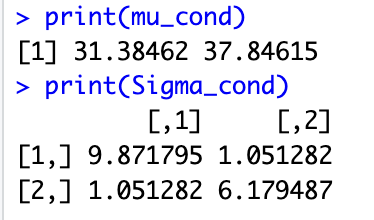
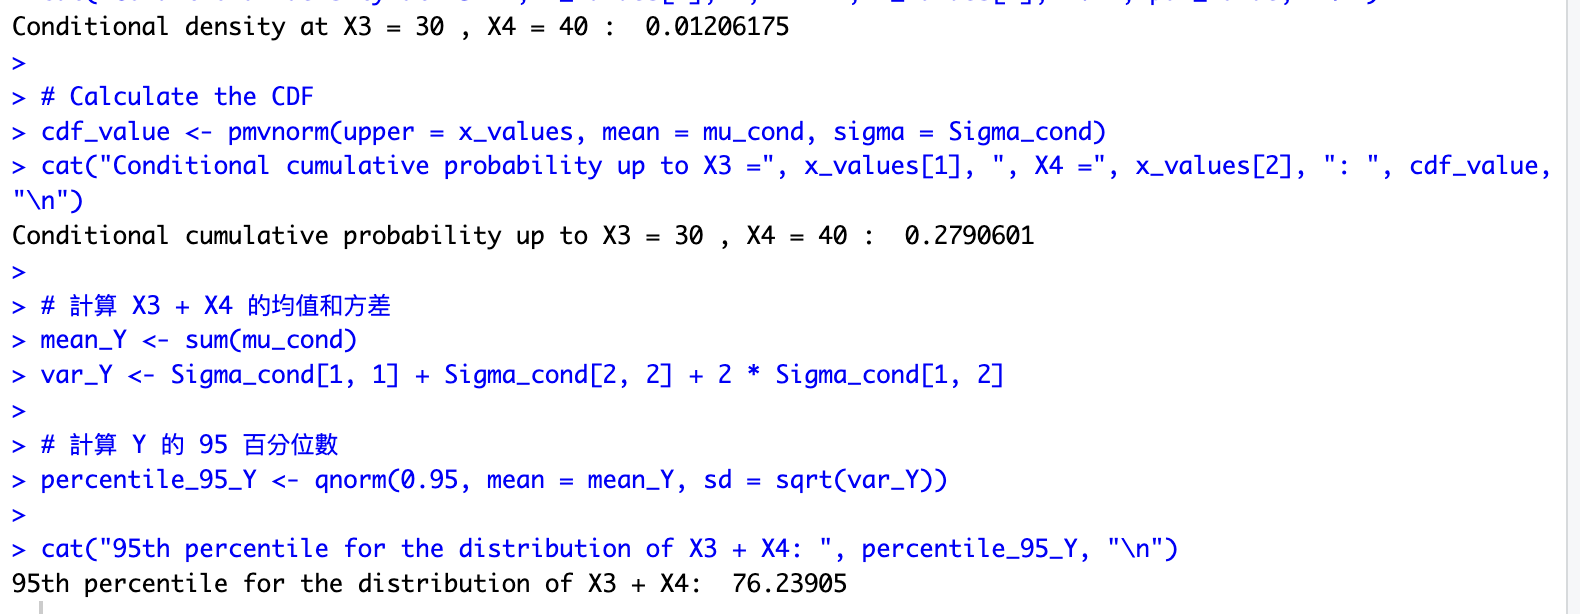


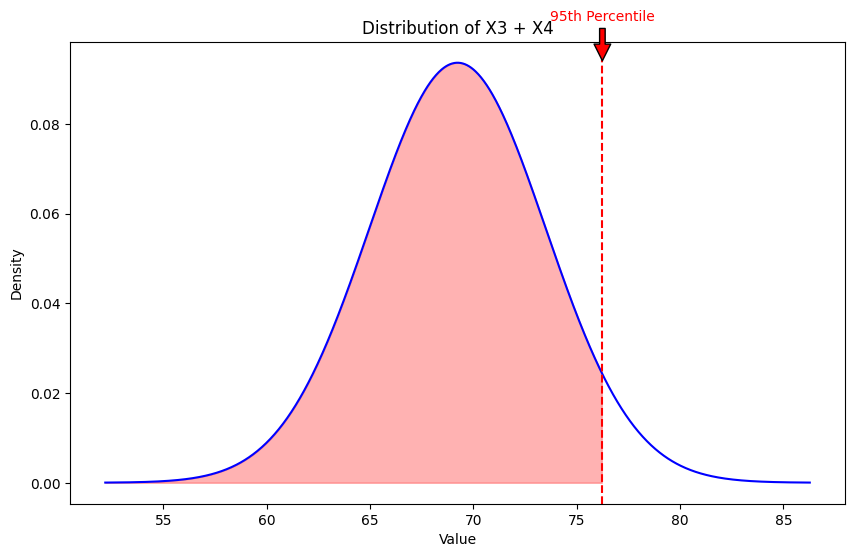

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


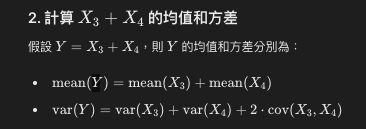


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [51]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.011275635130844
模擬計算的Y的方差: 2.962637071355294


### Calculate Qk hat for 2~T-1 of demand_df_train


In [52]:
demand_df_train = demand_folds[0][0]

In [53]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [54]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [55]:
Qk_hat_df

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,2626.423738,2517.459143,2425.585464,2425.025295,2574.669757,2574.669717,2315.420623,2182.502052
1,2727.372132,2037.309630,1983.760063,1983.661829,1857.538040,1857.538033,1741.373773,1531.344582
2,3733.998894,3218.032459,3202.867812,3202.814501,2896.901317,2896.901316,2690.104200,2583.431083
3,2855.963988,2375.951868,2352.608568,2352.552267,2145.958920,2145.958918,2235.289740,2184.402552
4,3156.117147,1938.038241,1986.173875,1986.806394,2193.011407,2193.011449,2100.720589,2025.524802
5,3076.588804,2329.903143,2325.403060,2325.554034,2131.112660,2131.112671,2128.626822,2031.341494
6,2515.715229,952.227981,955.173626,944.778985,851.860783,851.860100,773.684479,720.214964
7,2153.931734,1496.407086,1457.027899,1457.019439,1235.141816,1235.141816,1083.436641,988.925807
8,3153.692030,2462.418528,2425.965916,2425.926629,2117.747632,2117.747631,1997.562043,1907.537044
9,2805.226148,1581.393829,1547.725517,1547.982558,1517.384877,1517.384894,1365.047154,1167.097943


### Plot the distribuction


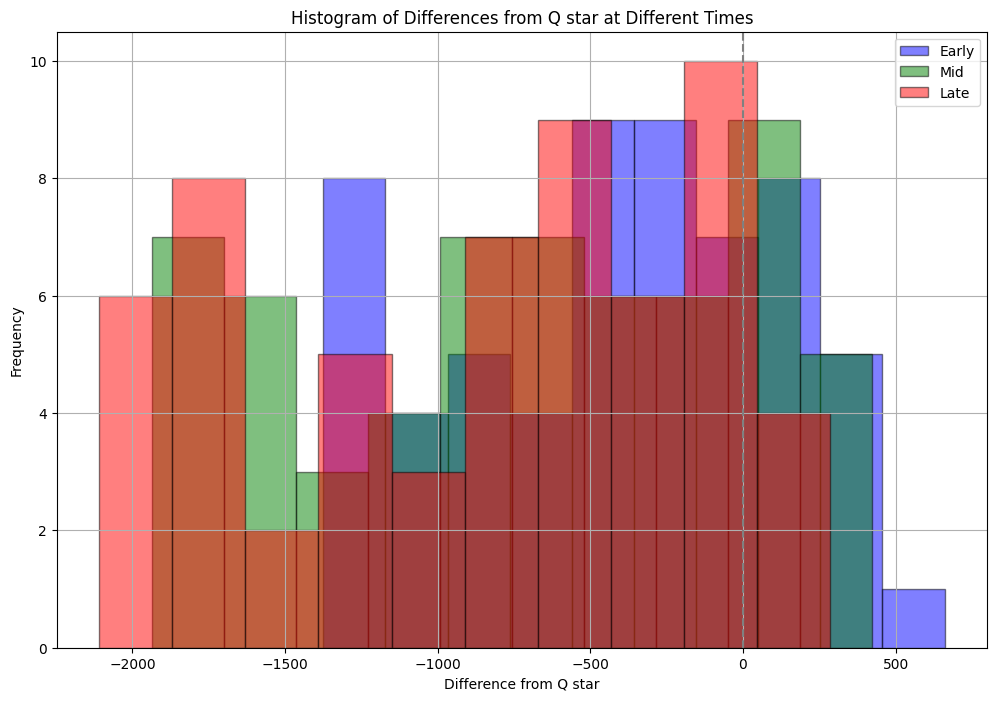

Q_star is: 2724.3655898465263
Early bias: -411.3163083707998
Mid bias: -698.5119299493497
Late bias: -857.0569783123793


In [56]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

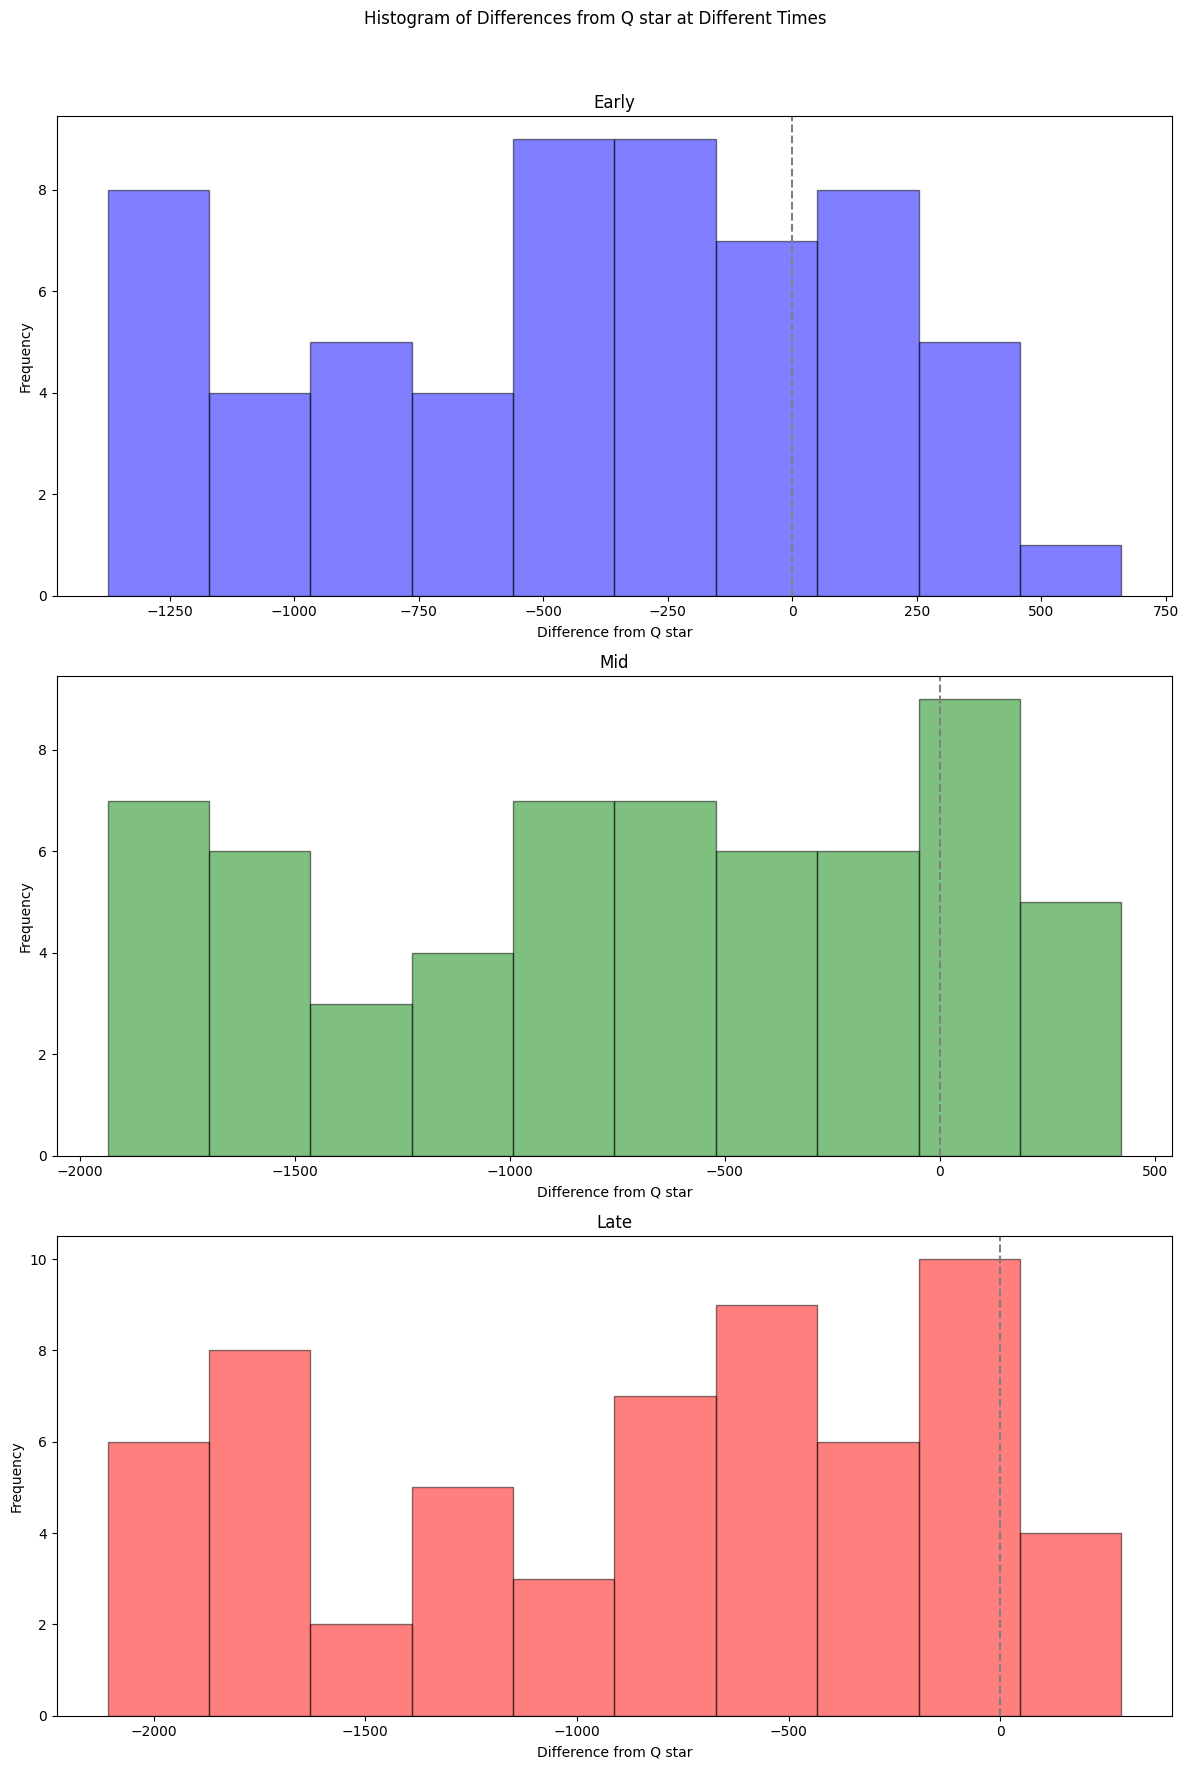

In [57]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## Validation

### Validate the r and R

In [58]:
# import gurobipy as gp
# from gurobipy import GRB

# # 初始化模型
# # model = gp.Model("Test_r_R_relationship")
# model = gp.Model(env=env)

# # 設定參數
# K = 4  # 候選數量
# i = 0  # 單個 i 的例子

# # 定義變數
# r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
# R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
# max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# # 假設 exp_tau_vars 是已知的輸入數值
# exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# # 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
# for k in range(K):
#     model.addConstr(
#         r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
#         name=f"softmax_relation_{k}",
#     )

# # 限制式 2: 確保 r_vars 的加總為 1
# model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# # 限制式 3: 找出 r_vars 中的最大值
# model.addGenConstrMax(
#     max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
# )

# # 限制式 4: 確保 R_vars 對應到最大值
# for k in range(K):
#     model.addGenConstrIndicator(
#         R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
#     )

# # 限制式 5: 確保僅有一個 R_vars[k] 為 1
# model.addConstr(
#     gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
# )

# # 設定目標函數（範例：最大化 max_r_helper）
# model.setObjective(max_r_helper, GRB.MAXIMIZE)

# # 求解模型
# model.optimize()

# # 輸出結果
# if model.Status == GRB.OPTIMAL:
#     print("Optimal solution found!")
#     print(f"max_r_helper: {max_r_helper.X}")
#     print("r_vars:")
#     for k in range(K):
#         print(f"  r_vars[{k}]: {r_vars[k].X}")
#     print("R_vars:")
#     for k in range(K):
#         print(f"  R_vars[{k}]: {R_vars[k].X}")
# else:
#     print("No optimal solution found.")

檢驗結果：目前的寫法可以成功讓 r 與 R 的關係實現



## S0 - One-time Procurement


In [59]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        # print("=" * 50)
        # print(
        #     f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        # )
        # print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            # print("-" * 50)
            # print(f"Day {day+1}")
            # print(f"Demand      : {demand}")
            # print(f"Sales       : {sales}")
            # print(f"Loss        : {loss}")
            # print(f"Left        : {left}")
            # print(f"Inventory   : {inventory}")
            # print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                # print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                # print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        # print("=" * 50)
        # print(f"Row {i+1} Summary")
        # print(f"Total Sold         : {total_sold}")
        # print(f"Total Lost         : {total_lost}")
        # print(f"Operation Profit   : {operation_profit}")
        # print(f"Profit             : {profit}")
        # print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    # print("=" * 50)
    # print("Overall Summary")
    # print(f"Average Losses           : {avg_losses}")
    # print(f"Average Lefts            : {avg_lefts}")
    # print(f"Average Operation Profits: {avg_operation_profits}")
    # print(f"Average Profits          : {avg_profits}")
    # print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [60]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    # print(f"\n")
    # print(f"====" * 10)
    # print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [61]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                # print(
                #     f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                # )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [62]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    # print(f"\n")
    # print(f"====" * 10)
    # print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [63]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                # print(
                #     f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                # )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [64]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):
    # print(
    #     f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    # )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Decision Variables =======================
        alphas = model.addVars(
            features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        )
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")

        f_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(xvar=f_vars[i], yvar=F_vars[i])

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # Calculate first period sales and lost sales
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"min_sales_constr_{i}",
            )

            # Calculate lost sales
            Lost_0_expr = total_demand_before_R - Q0_vars[i]
            Lost_0_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_expr_{i}")
            model.addConstr(Lost_0_var == Lost_0_expr)
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_var, 0], name=f"max_lost_constr_{i}"
            )

            # Calculate inventory left after first period
            left_0 = Q0_vars[i] - Sold_0s[i]

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # Calculate second period sales and lost sales
            total_stock_second_period = Q1_vars[i] + left_0
            total_stock_second_period_var = model.addVar(
                lb=0, name=f"total_stock_second_period_{i}"
            )
            model.addConstr(total_stock_second_period_var == total_stock_second_period)

            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, total_stock_second_period_var],
                name=f"min_sales2_constr_{i}",
            )

            # Calculate second period lost sales
            Lost_1_expr = total_demand_after_R - total_stock_second_period_var
            Lost_1_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_expr_{i}")
            model.addConstr(Lost_1_var == Lost_1_expr)

            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_var, 0], name=f"max_lost2_constr_{i}"
            )

            model.addConstr(Left_1s[i] == total_stock_second_period_var - Sold_1s[i])

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            # Calculate profit
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
                    - (cost - salvage_value) * Left_1s[i]  # Salvage cost
                    # - holding_cost * (holding_cost_1 + holding_cost_2)  # Holding cost
                )
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s2_model_debug.lp")
        model.write("s2_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X

                    # Record results
                    results["losses"].append(lost0 + lost1)
                    results["lefts"].append(left1)
                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q0s"].append(Q0_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)
                    results["Fs"].append(F_vars[i].X)

                    # print(f"\nObservation {i+1}:")
                    # print(f"Reorder day: {assigned_R}")
                    # print(f"Profit: {profits_vars[i].X:.2f}")

                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    alpha_values,
                    results["Fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [65]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")
            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        # print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            # print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S13 - Grid for Fixed Rk & Optimized F

In [66]:
def cal_optimized_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):
    print(
        f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Decision Variables =======================
        # alphas = model.addVars(
        #     features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        # )
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")

        # f_vars = model.addVars(
        #     len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        # )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            # model.addConstr(
            #     f_vars[i]
            #     == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            # )
            # model.addGenConstrLogistic(xvar=f_vars[i], yvar=F_vars[i])

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # Calculate first period sales and lost sales
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"min_sales_constr_{i}",
            )

            # Calculate lost sales
            Lost_0_expr = total_demand_before_R - Q0_vars[i]
            Lost_0_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_expr_{i}")
            model.addConstr(Lost_0_var == Lost_0_expr)
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_var, 0], name=f"max_lost_constr_{i}"
            )

            # Calculate inventory left after first period
            left_0 = Q0_vars[i] - Sold_0s[i]

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # Calculate second period sales and lost sales
            total_stock_second_period = Q1_vars[i] + left_0
            total_stock_second_period_var = model.addVar(
                lb=0, name=f"total_stock_second_period_{i}"
            )
            model.addConstr(total_stock_second_period_var == total_stock_second_period)

            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, total_stock_second_period_var],
                name=f"min_sales2_constr_{i}",
            )

            # Calculate second period lost sales
            Lost_1_expr = total_demand_after_R - total_stock_second_period_var
            Lost_1_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_expr_{i}")
            model.addConstr(Lost_1_var == Lost_1_expr)

            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_var, 0], name=f"max_lost2_constr_{i}"
            )

            model.addConstr(Left_1s[i] == total_stock_second_period_var - Sold_1s[i])

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            # Calculate profit
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
                    - (cost - salvage_value) * Left_1s[i]  # Salvage cost
                    # - holding_cost * (holding_cost_1 + holding_cost_2)  # Holding cost
                )
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s2_model_debug.lp")
        model.write("s2_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                # alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X

                    # Record results
                    results["losses"].append(lost0 + lost1)
                    results["lefts"].append(left1)
                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q0s"].append(Q0_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)
                    results["Fs"].append(F_vars[i].X)

                    print(f"\nObservation {i+1}:")
                    print(f"Reorder day: {assigned_R}")
                    print(f"Profit: {profits_vars[i].X:.2f}")

                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    None,
                    results["Fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [67]:
def grid_optimized_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        result = cal_optimized_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")
            results_dict["R(T)"].append(None)
            results_dict["R"].append(None)
            results_dict["average_losses"].append(None)
            results_dict["average_lefts"].append(None)
            results_dict["average_profits"].append(None)
            results_dict["average_operation_profits"].append(None)
            results_dict["alpha_values"].append(None)
            results_dict["F_vars"].append(None)
            results_dict["Q0_vars"].append(None)
            results_dict["Q1_vars"].append(None)

            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [68]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [69]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [70]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [71]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [72]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )
        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            # lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項

                # 定義指數變數
                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{p}")
                neg_tau_var = model.addVar(
                    lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(lb=0, name=f"sum_exp_tau_vars_{i}")
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            eps = 1e-10
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] >= max_r_helpers - eps
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            # model.addConstr(
            #     assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
            #     name=f"Calc_assigned_R_{i}",
            # )

            # # 計算 Holding_Cost_0
            # model.addConstr(
            #     Holding_Cost_0s[i]
            #     == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
            #     name=f"Constr_Holding_Cost_0_{i}",
            # )

            # # 計算 Holding_Cost_1
            # model.addConstr(
            #     Holding_Cost_1s[i]
            #     == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
            #     name=f"Constr_Holding_Cost_1_{i}",
            # )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * Left_1s[i]  # left cost
            #         # - holding_cost
            #         # * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s6_model_debug.lp")
        model.write("s6_model.mps")

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [73]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [74]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [75]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S4 - Beta with softmax


In [76]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )
                # model.addConstr(tau_vars[i, k] >= -5, name=f"tau_lb_{i}_{k}")

                exp_tau_var = model.addVar(lb=1e-6, name=f"exp_tau_var_{i}_{k}")
                exp_tau_var = model.addVar(
                    lb=-GRB.INFINITY, name=f"exp_tau_var_{i}_{k}"
                )
                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            model.addConstr(
                gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
                name=f"sum_r_{i}",
            )

            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], True, r_vars[i, k] == max_r_helpers
                )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [77]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S9 - Without beta

In [78]:
def __fully_flexible_beta_with_softmax_9(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        # betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        # r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                # print("Beta values:")
                # for key, beta in betas.items():
                #     print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                # beta_values = np.array(
                #     [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                # )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                # tau_values = np.array(
                #     [
                #         [tau_vars[i, j].X for j in range(K)]
                #         for i in range(len(demand_df_train))
                #     ]
                # )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                # all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        # rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        # )
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    # all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    None,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    None,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [79]:
def fully_flexible_beta_with_softmax_9(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_9(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S11 - Beta(Beta+Gamma)

In [80]:
def __fully_flexible_beta_with_softmax_11(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, lb=-GRB.INFINITY, name="betas")  # for intercept
        gammas = model.addVars(
            features_num, lb=-GRB.INFINITY, name="gammas"
        )  # for features coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        # Holding_Cost_0s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        # )

        # Holding_Cost_1s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        # )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * gammas[j]
                        for j in range(features_num)  # features coefficient
                    )
                    + betas[k],  # intercept
                    name=f"tau_computation_{i}_{k}",
                )

                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{k}")
                # neg_tau_var = model.addVar(
                #     lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{k}"
                # )

                # model.addConstr(
                #     neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                # )
                # model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            model.addConstr(
                gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
                name=f"sum_r_{i}",
            )

            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            # for k in range(K):
            #     model.addGenConstrIndicator(
            #         R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
            #     )

            epsilon = 1e-3  # 可調整的小正數
            for k in range(K):
                for k2 in range(K):
                    if k != k2:
                        model.addGenConstrIndicator(
                            R_vars[i, k],
                            True,
                            r_vars[i, k] >= r_vars[i, k2] + epsilon,
                            name=f"tau_diff_{i}_{k}_{k2}",
                        )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                # print("Beta values:")
                # for key, beta in betas.items():
                #     print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array([betas[k].X for k in range(K)])
                print(f"beta_values:\n{beta_values}")

                gamma_values = np.array([gammas[j].X for j in range(features_num)])
                print(f"gamma_values:\n{gamma_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                # all_holding_costs_0 = []
                # all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    # Holding_Cost_0 = Holding_Cost_0s[i].X
                    # Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    # all_holding_costs_0.append(Holding_Cost_0)
                    # all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    None,
                    None,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    gamma_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [81]:
def fully_flexible_beta_with_softmax_11(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_11(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            gamma_values,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            gamma_values=gamma_values,
        )

### S12 - Beta without r

In [82]:
def __fully_flexible_beta_with_softmax_12(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model(Alternative Model) ===================

            # Step 1: 利用線性回歸計算 tau
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")

            for k in range(K):
                # 如果候選 k 被選中 (R_vars[i,k] == 1)，則強制 tau_vars[i,k] 等於 tau_star
                model.addGenConstrIndicator(
                    R_vars[i, k],
                    True,
                    tau_vars[i, k] == tau_star,
                    name=f"tau_star_eq_{i}_{k}",
                )

                # 如果候選 k 未被選中 (R_vars[i,k] == 0)，則必須有 tau_vars[i,k] <= tau_star - delta
                # 利用 Big-M 技巧：當 R_vars[i,k]==0 時，約束變為 tau_vars[i,k] <= tau_star - delta
                # 當 R_vars[i,k]==1 時，由於前面的 indicator 約束已強制 tau_vars[i,k] == tau_star，
                # 此約束則不會影響模型（因為 tau_star <= tau_star - delta + M 已經成立）
                model.addConstr(
                    tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k],
                    name=f"tau_gap_{i}_{k}",
                )

            # Step 3: 保證只有一個候選被選中 (即 R_vars 為 1 的只有一個)
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"one_R_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                # print("Alphas values:")
                # for key, alpha in alphas.items():
                #     print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # print(f"------------")
                # print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [83]:
def fully_flexible_beta_with_softmax_12(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_12(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        # print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S14 - Optimized F & Rk

In [84]:
def __cal_optimized_F_R(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                # all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                #     for t in range(2):
                #         if t == 0:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                #             )
                #         else:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                #             )

                #     print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [85]:
def cal_optimized_F_R(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df,
    Qk_hat_df,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    (
        all_Rs,
        losses,
        lefts,
        profits,
        operation_profits,
        F_vars,
        Q0_vars,
        Q1_vars,
        all_holding_costs_0,
        all_holding_costs_1,
        all_left0s,
        all_left1s,
        all_lost0s,
        all_lost1s,
    ) = __cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    # 計算平均值
    average_losses = sum(losses) / len(losses) if losses else 0
    average_lefts = sum(lefts) / len(lefts) if lefts else 0
    average_profits = sum(profits) / len(profits) if profits else 0
    average_operation_profits = (
        sum(operation_profits) / len(operation_profits) if operation_profits else 0
    )

    # 將結果存儲到字典中
    results_dict["R(T)"].append(all_Rs)
    results_dict["average_losses"].append(average_losses)
    results_dict["average_lefts"].append(average_lefts)
    results_dict["average_profits"].append(average_profits)
    results_dict["average_operation_profits"].append(average_operation_profits)
    results_dict["alpha_values"].append(None)
    results_dict["F_vars"].append(F_vars)
    results_dict["Q0_vars"].append(Q0_vars)
    results_dict["Q1_vars"].append(Q1_vars)

    # print(f"The average profits is {average_profits}")

    if max_profit is None or max_profit < average_profits:
        # print(f"max_profit is changed from {max_profit} to {average_profits}")
        max_profit = average_profits
        max_profit_stimulation_result = {
            "R": all_Rs,
            "F": F_vars,
            "profits": profits,
            "losses": losses,
            "lefts": lefts,
            "operation_profits": operation_profits,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

### S15 - Beta with Lasso

In [86]:
def __fully_flexible_beta_with_lasso_15(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_beta,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")
        abs_betas = model.addVars(betas.keys(), lb=0, name="abs_beta")

        # 進行 lasso 處理
        for k, j in betas.keys():
            model.addConstr(abs_betas[k, j] >= betas[k, j])
            model.addConstr(abs_betas[k, j] >= -betas[k, j])

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model(Alternative Model) ===================

            # Step 1: 利用線性回歸計算 tau
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")

            for k in range(K):
                # 如果候選 k 被選中 (R_vars[i,k] == 1)，則強制 tau_vars[i,k] 等於 tau_star
                model.addGenConstrIndicator(
                    R_vars[i, k],
                    True,
                    tau_vars[i, k] == tau_star,
                    name=f"tau_star_eq_{i}_{k}",
                )

                model.addConstr(
                    tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k],
                    name=f"tau_gap_{i}_{k}",
                )

            # Step 3: 保證只有一個候選被選中 (即 R_vars 為 1 的只有一個)
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"one_R_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train)))
            - lambda_beta * gp.quicksum(abs_betas[k, j] for k, j in abs_betas.keys()),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                # print("Alphas values:")
                # for key, alpha in alphas.items():
                #     print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # print(f"------------")
                # print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                #     for t in range(2):
                #         if t == 0:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                #             )
                #         else:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                #             )

                #     print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [87]:
def fully_flexible_beta_with_lasso_15(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_beta,
):

    result = __fully_flexible_beta_with_lasso_15(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        lambda_beta=lambda_beta,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        # print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [88]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):
    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [89]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [90]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [91]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [92]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [93]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [94]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [95]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of tau_vars
        exp_tau_vars[i] = np.exp(tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S12 - Beta without r

In [96]:
def cal_test_fully_flexible_beta_with_softmax_12(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        print(f"tau: {tau_vars[i]}")
        print(f"R: {R_vars[i]}")
        print(f"max_r_index: {max_r_index[i]}")
        print("\n\n")

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S15 - Beta with Lasso

In [97]:
def cal_test_fully_flexible_beta_with_lasso_15(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        print(f"tau: {tau_vars[i]}")
        print(f"R: {R_vars[i]}")
        print(f"max_r_index: {max_r_index[i]}")
        print("\n\n")

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# MAIN


## Setting reasonable parameters


In [98]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202503250057

In [99]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.7


In [100]:
# training_df, testing_df = training_data_folds[0]
# demand_df_train, demand_df_test = demand_folds[0]

In [101]:
# training_df

In [102]:
demand_df_train

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,145.898688,231.313569,10.815686,231.313570,470.226719,231.313570,222.360630,176.632109,231.313570,231.313570
1,176.859937,175.331068,81.371862,175.331096,149.963831,175.331095,210.118668,36.374459,175.331095,175.331095
2,485.596120,289.020909,376.336644,289.020908,20.311809,289.020909,93.564299,162.517296,289.020909,289.020909
3,216.299539,210.997551,192.586949,210.997549,107.939667,210.997550,336.798423,275.789853,210.997550,210.997550
4,308.357633,155.963872,369.380315,155.963762,259.789273,155.963762,70.742527,237.435759,155.963762,155.963762
5,283.965993,201.598308,261.057169,201.598304,63.433728,201.598304,220.060138,194.832572,201.598304,201.598304
6,111.943975,57.219686,115.788421,54.798299,0.000000,54.798300,71.039367,145.029934,54.798301,54.798300
7,0.983628,125.393913,8.661834,125.393704,78.582722,125.393704,138.236747,135.491773,125.393704,125.393704
8,307.613840,215.043375,203.109888,215.043384,3.256296,215.043384,171.405372,146.934364,215.043384,215.043384
9,200.738054,122.517963,106.712210,122.519402,124.600960,122.519402,122.450775,0.000000,122.519402,122.519402


In [103]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 1732.2318586536417
std of sum: 603.174480048829
70.0 percentile of sum: 2048.5368652436537
Q_star: 2048.5368652436537


In [104]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,1670.034679,2135.475853,2025.237203,2027.688866,2231.920540,2231.920537,2184.174339,2182.501783
1,1776.907065,1765.664417,1644.757170,1642.795317,1592.915906,1592.915922,1599.996829,1531.344310
2,2842.606085,2887.280583,2832.988846,2835.818858,2736.867358,2736.867353,2611.409965,2583.430814
3,1913.045126,2060.275187,2160.054452,2161.295448,2063.935192,2063.935186,2184.777074,2184.402283
4,2230.812286,1758.185084,1938.112955,1934.749084,2095.089862,2095.089864,2035.214468,2025.524530
5,2146.616951,2060.483135,2125.236666,2124.827408,2030.463720,2030.463728,2060.078021,2031.341224
6,1552.829420,855.556955,790.072656,798.480701,762.411154,762.411152,733.570043,720.214685
7,1169.815248,1232.848295,1327.488096,1325.149368,1147.773715,1147.773713,999.905322,988.925536
8,2228.244855,2180.298011,2065.536084,2064.889435,1909.040914,1909.040916,1877.450254,1907.536775
9,1859.329818,1411.473747,1196.258200,1189.755766,1174.185869,1174.185863,1169.354693,1167.097670


## K-folds training

### Pre-Settings

In [105]:
len(training_data_folds), len(demand_folds)

(3, 3)

### Training & Testing Function 

In [106]:
# This is for single fold training.
def perform_fold_training(
    training_df, demand_df_train, Qk_hat_df_train, Q_star
) -> dict[str, float]:

    # 1. Baseline model
    (
        baseline_avg_losses,
        baseline_avg_lefts,
        baseline_avg_profits,
        baseline_avg_operation_profits,
        baseline_stimulation_df,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_train,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    # 2. S1 - Grid F & Grid R

    results_df_1, stimulation_results_df_1 = None, None

    results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        assigned_Fs=ASSIGNED_FS,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
        Qk_hat_df=Qk_hat_df_train,
        demand_df_train=demand_df_train,
        Q_star=Q_star,
    )

    S1_profit_training = results_df_1.iloc[0]["average_profits"]

    # 3. S2 - Grid R & Flexible F

    results_df_2, stimulation_results_df_2 = None, None
    results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df_train=Qk_hat_df_train,
        training_df=training_df,
    )

    S2_profit_training = results_df_2.iloc[0]["average_profits"]

    # 4. S12 - Beta without r

    results_df_12, stimulation_results_df_12 = None, None
    results_df_12, stimulation_results_df_12 = fully_flexible_beta_with_softmax_12(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    if results_df_12 is not None:
        S12_profit_training = results_df_12.iloc[0]["average_profits"]
    else:
        S12_profit_training = None

    # 5. S14 - Optimized F & Rk
    results_df_14, stimulation_results_df_14 = None, None
    results_df_14, stimulation_results_df_14 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    S14_profit_training = results_df_14.iloc[0]["average_profits"]

    # 6. S15 - Beta with Lasso
    results_df_15, stimulation_results_df_15 = None, None
    results_df_15, stimulation_results_df_15 = fully_flexible_beta_with_lasso_15(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
        lambda_beta=LASSO_BETA,
    )
    if results_df_15 is not None:
        S15_profit_training = results_df_15.iloc[0]["average_profits"]
    else:
        S15_profit_training = None

    print(f"baseline_profit: {baseline_avg_profits}")
    print(f"S1_profit_training: {S1_profit_training}")
    print(f"S2_profit_training: {S2_profit_training}")
    print(f"S12_profit_training: {S12_profit_training}")
    print(f"S14_profit_training: {S14_profit_training}")
    print(f"S15_profit_training: {S15_profit_training}")

    # 整理利潤結果
    training_profits = {
        "baseline": baseline_avg_profits,
        "S1": S1_profit_training,
        "S2": S2_profit_training,
        "S12": S12_profit_training,
        "S15": S15_profit_training,
        "S14": S14_profit_training,
    }

    training_results = {
        "S1": results_df_1,
        "S2": results_df_2,
        "S12": results_df_12,
        "S15": results_df_15,
        "S14": results_df_14,
    }

    training_stimulation_results = {
        "baseline": baseline_stimulation_df,
        "S1": stimulation_results_df_1,
        "S2": stimulation_results_df_2,
        "S12": stimulation_results_df_12,
        "S15": stimulation_results_df_15,
        "S14": stimulation_results_df_14,
    }

    return training_profits, training_results, training_stimulation_results

In [107]:
# This is for single fold testing.


def perform_fold_testing(
    results_df_1,
    results_df_2,
    results_df_12,
    results_df_15,
    demand_df_test,
    Qk_hat_df_test,
    Q_star,
    testing_df,
) -> dict[str, float]:

    # 1. Baseline model

    (
        test_baseline_avg_loss,
        test_baseline_avg_lefts,
        test_baseline_avg_profits,
        test_baseline_avg_operation_profits,
        test_stimulation_df_baseline,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_test,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    print(f"baseline_profit: {test_baseline_avg_profits}")

    # 2. S1 - Grid F & Grid R
    if results_df_1 is not None:
        assigned_T = results_df_1.iloc[0]["R(T)"]
        assigned_F = results_df_1.iloc[0]["F"]

        test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
        )

    S1_profit_testing = test_results_df_1.iloc[0]["average_profits"]

    # 3. S2 - Grid R & Flexible F

    if results_df_2 is not None and len(results_df_2) > 0:
        assigned_R = results_df_2.iloc[0]["R"]
        alphas = results_df_2.iloc[0]["alpha_values"]

        test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
            assigned_R=assigned_R[0],
            alphas=alphas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )

    S2_profit_testing = test_results_df_2.iloc[0]["average_profits"]

    # 4. S12 - Beta without r
    test_results_df_12, test_stimulation_results_df_12 = None, None
    if results_df_12 is not None:
        alphas = results_df_12.iloc[0]["alpha_values"]
        betas = results_df_12.iloc[0]["beta_values"]

        test_results_df_12, test_stimulation_results_df_12 = (
            cal_test_fully_flexible_beta_with_softmax_12(
                alphas=alphas,
                betas=betas,
                salvage_value=salvage_value,
                cost=cost,
                price=price,
                Q_star=Q_star,
                demand_df_test=demand_df_test,
                Qk_hat_df_test=Qk_hat_df_test,
                testing_df=testing_df,
            )
        )
        S12_profit_testing = test_results_df_12.iloc[0]["average_profits"]
    else:
        S12_profit_testing = None

    # 5. S14 - Optimized F & Rk
    test_results_df_14, test_stimulation_results_df_14 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_test,
        Qk_hat_df=Qk_hat_df_test,
        training_df=testing_df,
    )

    S14_profit_testing = test_results_df_14.iloc[0]["average_profits"]

    # 6. S15 - Beta with Lasso
    test_results_df_15, test_stimulation_results_df_15 = None, None
    if results_df_15 is not None:
        alphas = results_df_15.iloc[0]["alpha_values"]
        betas = results_df_15.iloc[0]["beta_values"]

        test_results_df_15, test_stimulation_results_df_15 = (
            cal_test_fully_flexible_beta_with_lasso_15(
                alphas=alphas,
                betas=betas,
                salvage_value=salvage_value,
                cost=cost,
                price=price,
                Q_star=Q_star,
                demand_df_test=demand_df_test,
                Qk_hat_df_test=Qk_hat_df_test,
                testing_df=testing_df,
            )
        )
        S15_profit_testing = test_results_df_15.iloc[0]["average_profits"]
    else:
        S15_profit_testing = None

    print(f"baseline_profit: {test_baseline_avg_profits}")
    print(f"S1_profit_testing: {S1_profit_testing}")
    print(f"S2_profit_testing: {S2_profit_testing}")
    print(f"S12_profit_testing: {S12_profit_testing}")
    print(f"S14_profit_testing: {S14_profit_testing}")
    print(f"S15_profit_testing: {S15_profit_testing}")

    # 整理利潤結果
    testing_profits = {
        "baseline": test_baseline_avg_profits,
        "S1": S1_profit_testing,
        "S2": S2_profit_testing,
        "S12": S12_profit_testing,
        "S15": S15_profit_testing,
        "S14": S14_profit_testing,
    }

    testing_stimulation_results = {
        "baseline": test_stimulation_df_baseline,
        "S1": test_stimulation_results_df_1,
        "S2": test_stimulation_results_df_2,
        "S12": test_stimulation_results_df_12,
        "S15": test_stimulation_results_df_15,
        "S14": test_stimulation_results_df_14,
    }

    return testing_profits, testing_stimulation_results

### Main

In [108]:
train_all_fold_profits = []
train_all_fold_stimulation_results = []
test_all_fold_profits = []
test_all_fold_stimulation_results = []
beta_records = {"S12": [], "S15": []}

# 迴圈遍歷所有 fold
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    # ====訓練階段====

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
    Qk_hat_df_train = make_Qk_hat_df(
        demand_df_train, T, service_lv, mu_matrix, covariance_matrix
    )
    training_profits, training_results, training_stimulation_results = (
        perform_fold_training(training_df, demand_df_train, Qk_hat_df_train, Q_star)
    )
    train_all_fold_profits.append(training_profits)
    train_all_fold_stimulation_results.append(training_stimulation_results)

    if training_results["S12"] is not None:
        beta_records["S12"].append(training_results["S12"].iloc[0]["beta_values"])
    else:
        beta_records["S12"].append(None)

    if training_results["S15"] is not None:
        beta_records["S15"].append(training_results["S15"].iloc[0]["beta_values"])
    else:
        beta_records["S15"].append(None)

    # ====測試階段====
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
    Qk_hat_df_test = make_Qk_hat_df(
        demand_df_test, T, service_lv, mu_matrix, covariance_matrix
    )
    testing_profits, testing_stimulation_results = perform_fold_testing(
        training_results["S1"],
        training_results["S2"],
        training_results["S12"],
        training_results["S15"],
        demand_df_test,
        Qk_hat_df_test,
        Q_star,
        testing_df,
    )

    test_all_fold_profits.append(testing_profits)
    test_all_fold_stimulation_results.append(testing_stimulation_results)


# 將所有 fold 的結果轉換為 DataFrame 便於檢查與保存
train_all_fold_profit_df = pd.DataFrame(train_all_fold_profits)
print("All train fold profits:")
print(train_all_fold_profit_df)

test_all_fold_profit_df = pd.DataFrame(test_all_fold_profits)
print("All test fold profits:")
print(test_all_fold_profit_df)

===== Processing Fold 1 =====
mean of sum: 1732.2318586536417
std of sum: 603.174480048829
70.0 percentile of sum: 2048.5368652436537
Fold 1 Q_star: 2048.5368652436537
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 100 rows, 145 columns and 290 nonzeros
Model fingerprint: 0x8f7ab0da
Model has 60 general constraints
Variable types: 145 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [1e+00, 2e+03]
Presolve added 80 rows and 90 columns
Presolve time: 0.00s
Presolved: 18

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/982154738.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H  711   721                    1.138325e+07 1.2126e+07  6.52%   8.7    0s
*  771   721              50    1.158893e+07 1.2126e+07  4.63%   8.8    0s
*  865   770              50    1.170367e+07 1.2126e+07  3.61%   8.6    0s
H  899   770                    1.181995e+07 1.2126e+07  2.59%   8.6    0s
* 1057   748              40    1.183442e+07 1.2126e+07  2.46%   9.0    0s
* 1493   853              52    1.203495e+07 1.2126e+07  0.75%  10.0    0s

Cutting planes:
  Gomory: 6
  Cover: 3
  Implied bound: 12
  MIR: 2
  Flow cover: 5
  Relax-and-lift: 1

Explored 1559 nodes (16327 simplex iterations) in 0.25 seconds (0.34 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 1.20349e+07 1.18344e+07 1.182e+07 ... 6.74793e+06

Optimal solution found (tolerance 1.00e-02)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 1.203494776236e+07, best bound

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3949304585.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/2861697828.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeW

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 100 rows, 145 columns and 290 nonzeros
Model fingerprint: 0x1c5f1dee
Model has 60 general constraints
Variable types: 145 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [1e+01, 3e+03]
Presolve added 83 rows and 93 columns
Presolve time: 0.00s
Presolved: 183 rows, 238 columns, 1176 nonzeros
Variable types: 181 continuous, 57 integer (37 binary)
Found heuristic solution: objective 9991592.7235

Root relaxation: objective 1

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/982154738.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3949304585.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/2861697828.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

     0     0 1.5212e+07    0   37 9991592.62 1.5212e+07  52.3%     -    0s
     0     0 1.5212e+07    0   37 9991592.62 1.5212e+07  52.3%     -    0s
     0     0 1.5212e+07    0   32 9991592.62 1.5212e+07  52.3%     -    0s
     0     0 1.5212e+07    0   33 9991592.62 1.5212e+07  52.3%     -    0s
     0     0 1.5212e+07    0   36 9991592.62 1.5212e+07  52.3%     -    0s
     0     0 1.5212e+07    0   36 9991592.62 1.5212e+07  52.3%     -    0s
     0     2 1.5212e+07    0   35 9991592.62 1.5212e+07  52.3%     -    0s
H   29    38                    9991595.9338 1.5212e+07  52.3%  20.3    0s
H   32    38                    1.000503e+07 1.5212e+07  52.0%  20.7    0s
H  502   535                    1.174906e+07 1.5212e+07  29.5%  14.0    0s
H  565   620                    1.467467e+07 1.5212e+07  3.66%  14.0    0s
*  586   620              39    1.478458e+07 1.5212e+07  2.89%  13.6    0s
H  708   679                    1.503043e+07 1.5212e+07  1.21%  13.6    0s
H  748   679             

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/363998

     0     0 1.3293e+07    0   21 8407638.51 1.3293e+07  58.1%     -    0s
     0     0 1.3293e+07    0   15 8407638.51 1.3293e+07  58.1%     -    0s
     0     0 1.3293e+07    0   14 8407638.51 1.3293e+07  58.1%     -    0s
     0     0 1.3293e+07    0   12 8407638.51 1.3293e+07  58.1%     -    0s
     0     0 1.3293e+07    0   12 8407638.51 1.3293e+07  58.1%     -    0s
     0     0 1.3293e+07    0   12 8407638.51 1.3293e+07  58.1%     -    0s
     0     0 1.3293e+07    0   12 8407638.51 1.3293e+07  58.1%     -    0s
     0     2 1.3293e+07    0   12 8407638.51 1.3293e+07  58.1%     -    0s
H  120   125                    9422503.3392 1.3293e+07  41.1%  10.3    0s
H  215   174                    1.129932e+07 1.3293e+07  17.6%   9.8    0s
H  232   174                    1.161527e+07 1.3293e+07  14.4%   9.7    0s
*  272   195              19    1.167488e+07 1.3293e+07  13.9%  10.1    0s
*  284   195              22    1.229503e+07 1.3293e+07  8.12%   9.9    0s
H  294   195             

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/982154738.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H 1730   797                    1.388471e+07 1.3975e+07  0.65%  10.4    0s
H 1872   797                    1.389247e+07 1.3975e+07  0.59%  10.6    0s

Cutting planes:
  Gomory: 2
  Cover: 6
  Implied bound: 8
  MIR: 5
  Flow cover: 8
  Inf proof: 1

Explored 2003 nodes (22195 simplex iterations) in 0.30 seconds (0.40 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 1.38925e+07 1.38847e+07 1.3781e+07 ... 1.28708e+07

Optimal solution found (tolerance 1.00e-02)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 1.389247162536e+07, best bound 1.397510027436e+07, gap 0.5948%

model.status is optimal: True
model.status is TIME_LIMIT: False

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter IntFeasTol to value 1e-09
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[ar

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3949304585.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/2861697828.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H  603   642                    1.245063e+07 1.3975e+07  12.2%  17.5    0s
*  644   642              40    1.262814e+07 1.3975e+07  10.7%  16.9    0s
H  687   657                    1.347755e+07 1.3975e+07  3.69%  16.7    0s
H  688   657                    1.378002e+07 1.3975e+07  1.42%  16.7    0s
H  689   657                    1.388572e+07 1.3975e+07  0.64%  16.7    0s

Cutting planes:
  Gomory: 7
  Cover: 3
  Implied bound: 5
  MIR: 6
  Flow cover: 8
  GUB cover: 1
  Relax-and-lift: 3

Explored 715 nodes (12465 simplex iterations) in 0.28 seconds (0.36 work units)
Thread count was 12 (of 12 available processors)

Solution count 6: 1.38857e+07 1.378e+07 1.34776e+07 ... 7.3583e+06

Optimal solution found (tolerance 1.00e-02)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 1.388571731379e+07, best bound 1.397510007277e+07, gap 0.6437%

model.status is optimal: True


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_1907/363998

In [109]:
train_all_fold_profit_df

,baseline,S1,S2,S12,S15,S14
0,9.808677e+05,1.138266e+06,1.207651e+06,1.203495e+06,1.207136e+06,1.212562e+06
1,1.318419e+06,1.478136e+06,1.521227e+06,1.511930e+06,1.515111e+06,1.521227e+06
2,1.081650e+06,1.327696e+06,1.397510e+06,1.389247e+06,1.388572e+06,1.397510e+06


In [110]:
test_all_fold_profit_df

,baseline,S1,S2,S12,S15,S14
0,1.061162e+06,1.178543e+06,1.088493e+06,9.471121e+05,6.261811e+05,1.239763e+06
1,8.639913e+05,1.112857e+06,9.910601e+05,1.042900e+06,8.905329e+05,1.166418e+06
2,6.616597e+05,9.896494e+05,9.387878e+05,9.694101e+05,1.001954e+06,1.074529e+06


### Analysis

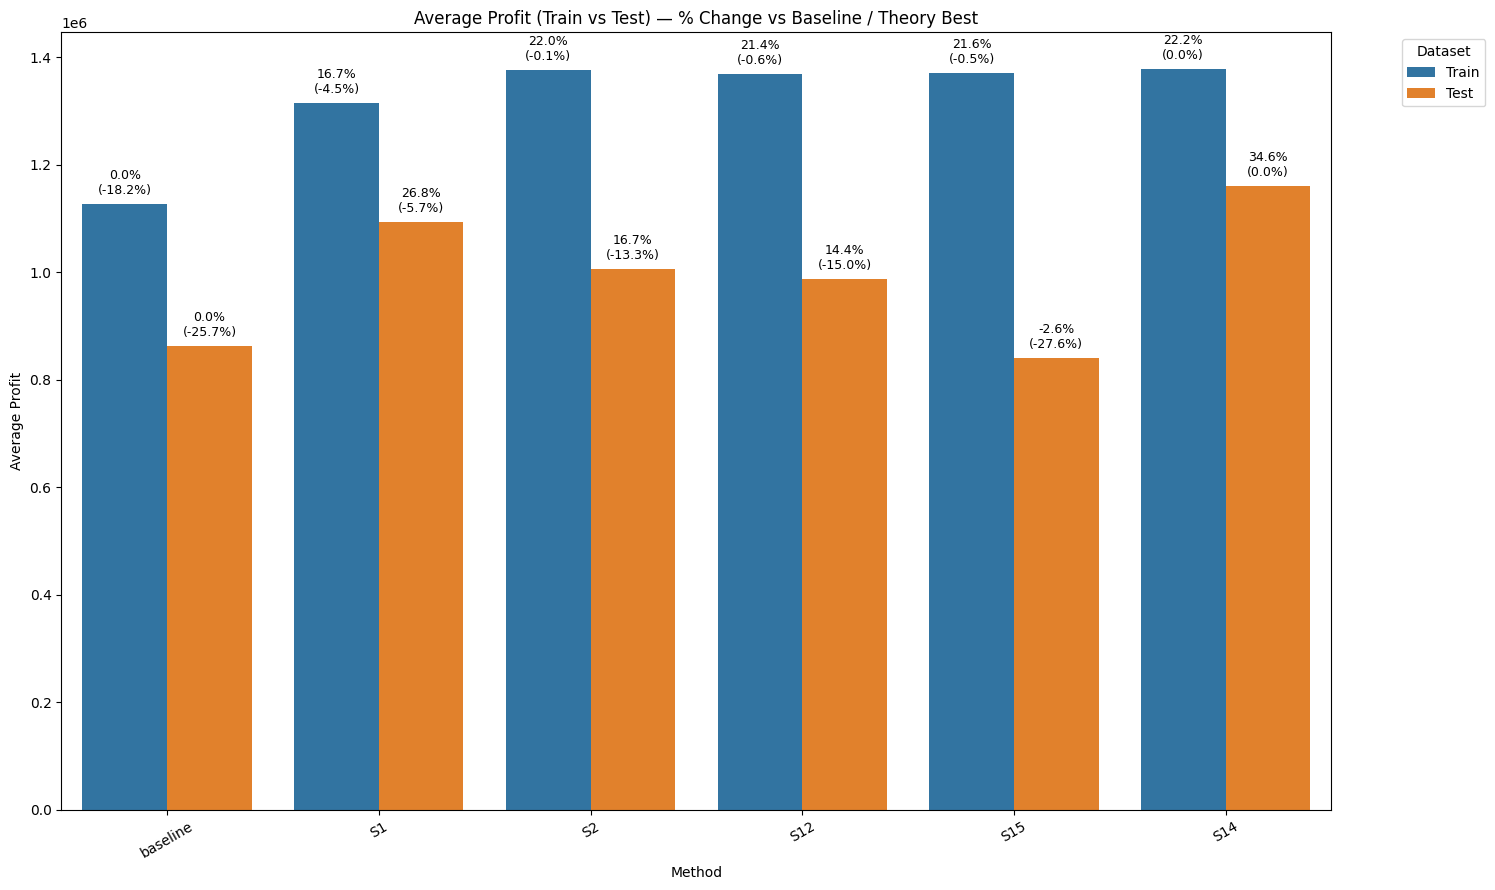

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ 計算平均 profit
train_means = train_all_fold_profit_df.mean()
test_means = test_all_fold_profit_df.mean()

# 2️⃣ 定義 baseline & theory best
baseline_train = train_means["baseline"]
baseline_test = test_means["baseline"]
theory_best_train = train_means["S14"]
theory_best_test = test_means["S14"]

# 3️⃣ 計算百分比變化：baseline & theory
train_pct_base = (train_means - baseline_train) / baseline_train * 100
test_pct_base = (test_means - baseline_test) / baseline_test * 100
train_pct_theory = (train_means - theory_best_train) / theory_best_train * 100
test_pct_theory = (test_means - theory_best_test) / theory_best_test * 100

# 4️⃣ 建 DataFrame
avg_df = pd.DataFrame(
    {
        "Method": train_means.index,
        "Train": train_means.values,
        "Test": test_means.values,
        "Train_%_Base": train_pct_base.values,
        "Test_%_Base": test_pct_base.values,
        "Train_%_Theory": train_pct_theory.values,
        "Test_%_Theory": test_pct_theory.values,
    }
)

avg_df_melted = avg_df.melt(
    id_vars=[
        "Method",
        "Train_%_Base",
        "Test_%_Base",
        "Train_%_Theory",
        "Test_%_Theory",
    ],
    value_vars=["Train", "Test"],
    var_name="Dataset",
    value_name="Average Profit",
)

# 5️⃣ 畫圖
plt.figure(figsize=(15, 9))
ax = sns.barplot(x="Method", y="Average Profit", hue="Dataset", data=avg_df_melted)

# 6️⃣ 標註：baseline (%) 在第一行、theory (%) 括號內第二行
for patch, (method, ds) in zip(
    ax.patches, zip(avg_df_melted["Method"], avg_df_melted["Dataset"])
):
    if ds == "Train":
        pct_base = avg_df.loc[avg_df.Method == method, "Train_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Train_%_Theory"].values[0]
    else:
        pct_base = avg_df.loc[avg_df.Method == method, "Test_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Test_%_Theory"].values[0]

    ax.annotate(
        f"{pct_base:.1f}%\n({pct_theory:.1f}%)",
        (patch.get_x() + patch.get_width() / 2, patch.get_height()),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.title("Average Profit (Train vs Test) — % Change vs Baseline / Theory Best")
plt.ylabel("Average Profit")
plt.xlabel("Method")
plt.xticks(rotation=30)
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

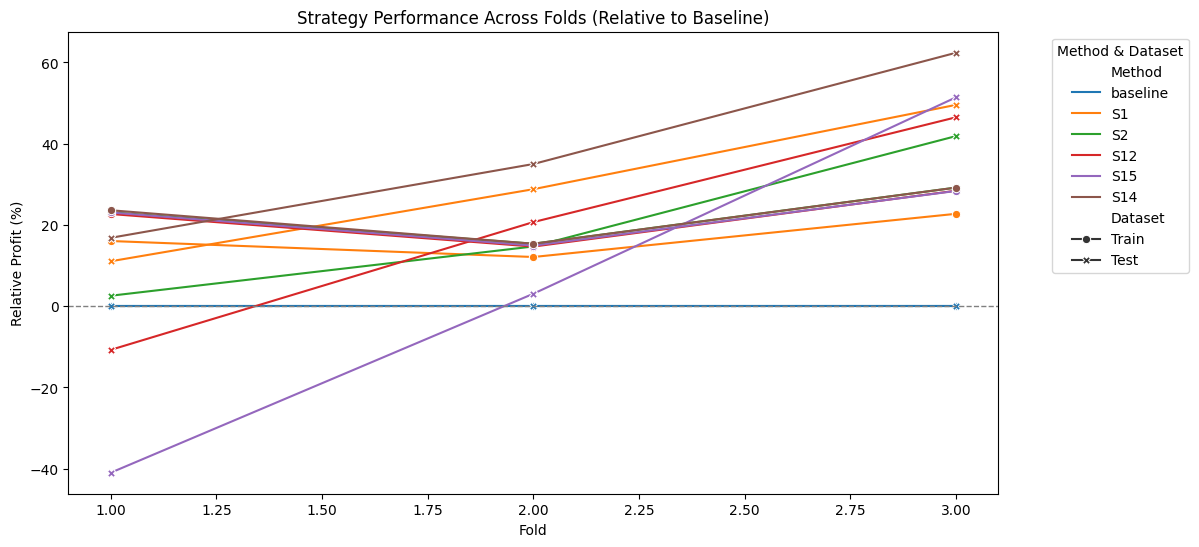

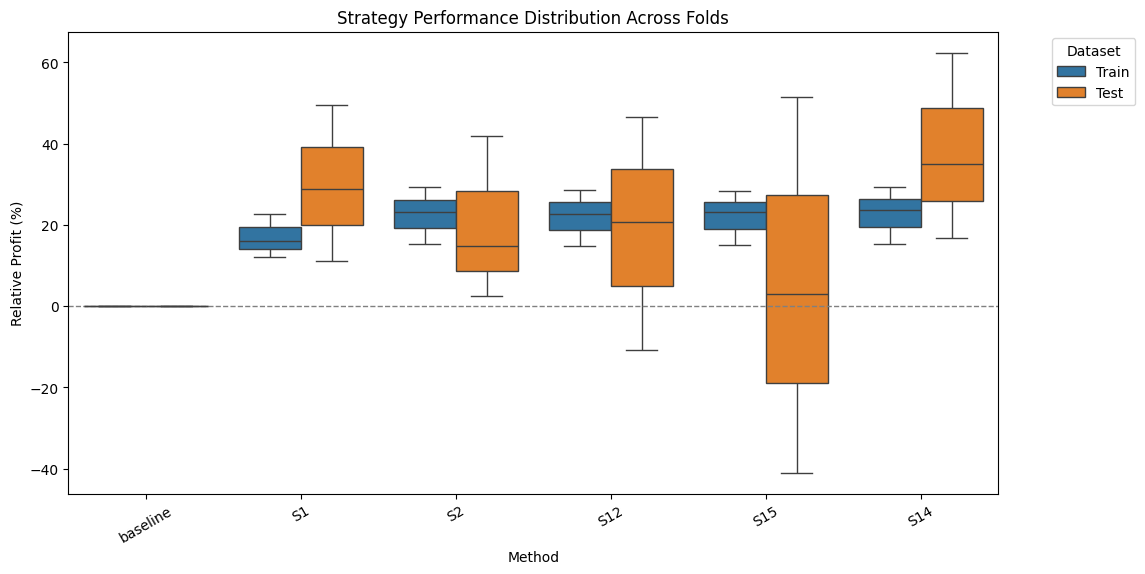

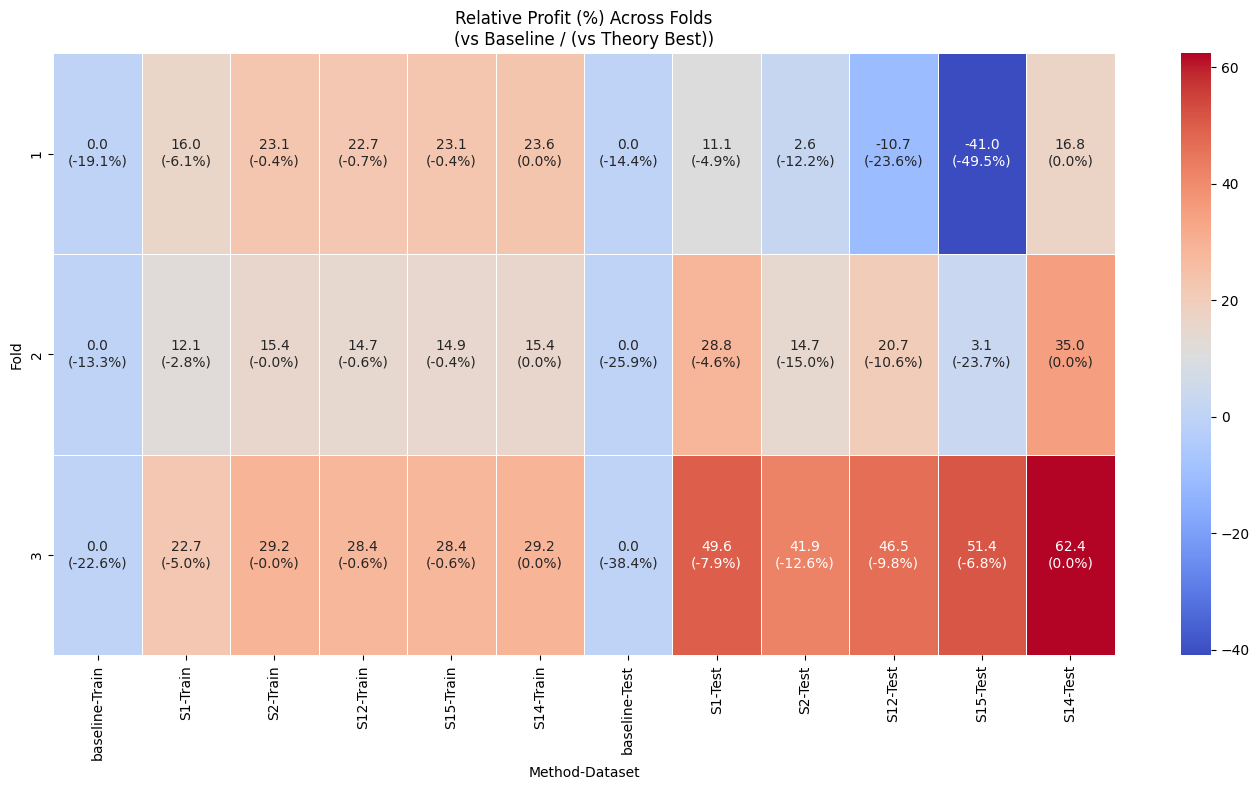

In [112]:
# 計算 baseline（訓練與測試）
baseline_train = train_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)
baseline_test = test_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)

# 計算百分比變化
train_relative = (
    (train_all_fold_profit_df.to_numpy() - baseline_train) / baseline_train * 100
)
test_relative = (
    (test_all_fold_profit_df.to_numpy() - baseline_test) / baseline_test * 100
)

# 轉回 DataFrame，並保留 column names
train_relative = pd.DataFrame(
    train_relative,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
test_relative = pd.DataFrame(
    test_relative,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)

# 加入 fold 編號
train_relative["Fold"] = train_relative.index + 1
test_relative["Fold"] = test_relative.index + 1

# 轉換成長格式
train_long = train_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
train_long["Dataset"] = "Train"

test_long = test_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
test_long["Dataset"] = "Test"

# 合併數據
fold_long = pd.concat([train_long, test_long], axis=0)

# === 1. 使用線圖 (Line Plot) 觀察不同 Fold 上的變化趨勢 ===
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=fold_long,
    x="Fold",
    y="Relative Profit (%)",
    hue="Method",
    style="Dataset",
    markers=True,
    dashes=False,
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # 基準線
plt.title("Strategy Performance Across Folds (Relative to Baseline)")
plt.legend(title="Method & Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# === 2. 使用箱型圖 (Box Plot) 查看策略穩定性 ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=fold_long, x="Method", y="Relative Profit (%)", hue="Dataset")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Strategy Performance Distribution Across Folds")
plt.xticks(rotation=30)
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# 3️⃣ Heatmap：同時顯示 vs Baseline & vs Theory Best（每 Fold 的 S14）
theory_best_train = train_all_fold_profit_df["S14"].to_numpy().reshape(-1, 1)
theory_best_test = test_all_fold_profit_df["S14"].to_numpy().reshape(-1, 1)

# vs Theory (%) 計算
train_theory_rel = (
    (train_all_fold_profit_df.to_numpy() - theory_best_train) / theory_best_train * 100
)
test_theory_rel = (
    (test_all_fold_profit_df.to_numpy() - theory_best_test) / theory_best_test * 100
)

# 回 DataFrame 並 melt
train_theory_rel = pd.DataFrame(
    train_theory_rel,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
train_theory_rel["Fold"] = train_theory_rel.index + 1
train_theory_long = train_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
train_theory_long["Dataset"] = "Train"

test_theory_rel = pd.DataFrame(
    test_theory_rel,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)
test_theory_rel["Fold"] = test_theory_rel.index + 1
test_theory_long = test_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
test_theory_long["Dataset"] = "Test"

# 合併 baseline (%) 與 theory (%) 資料
merged = fold_long.merge(
    pd.concat([train_theory_long, test_theory_long], axis=0),
    on=["Fold", "Method", "Dataset"],
)

# Pivot heatmap values + annotations
heatmap_data = merged.pivot(
    index="Fold", columns=["Method", "Dataset"], values="Relative Profit (%)"
)
annot = merged.assign(
    annot=merged["Relative Profit (%)"].round(1).astype(str)
    + "\n("
    + merged["Relative vs Theory (%)"].round(1).astype(str)
    + "%)"
).pivot(index="Fold", columns=["Method", "Dataset"], values="annot")

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=annot, fmt="", cmap="coolwarm", linewidths=0.5)
plt.title("Relative Profit (%) Across Folds\n(vs Baseline / (vs Theory Best))")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_0.png


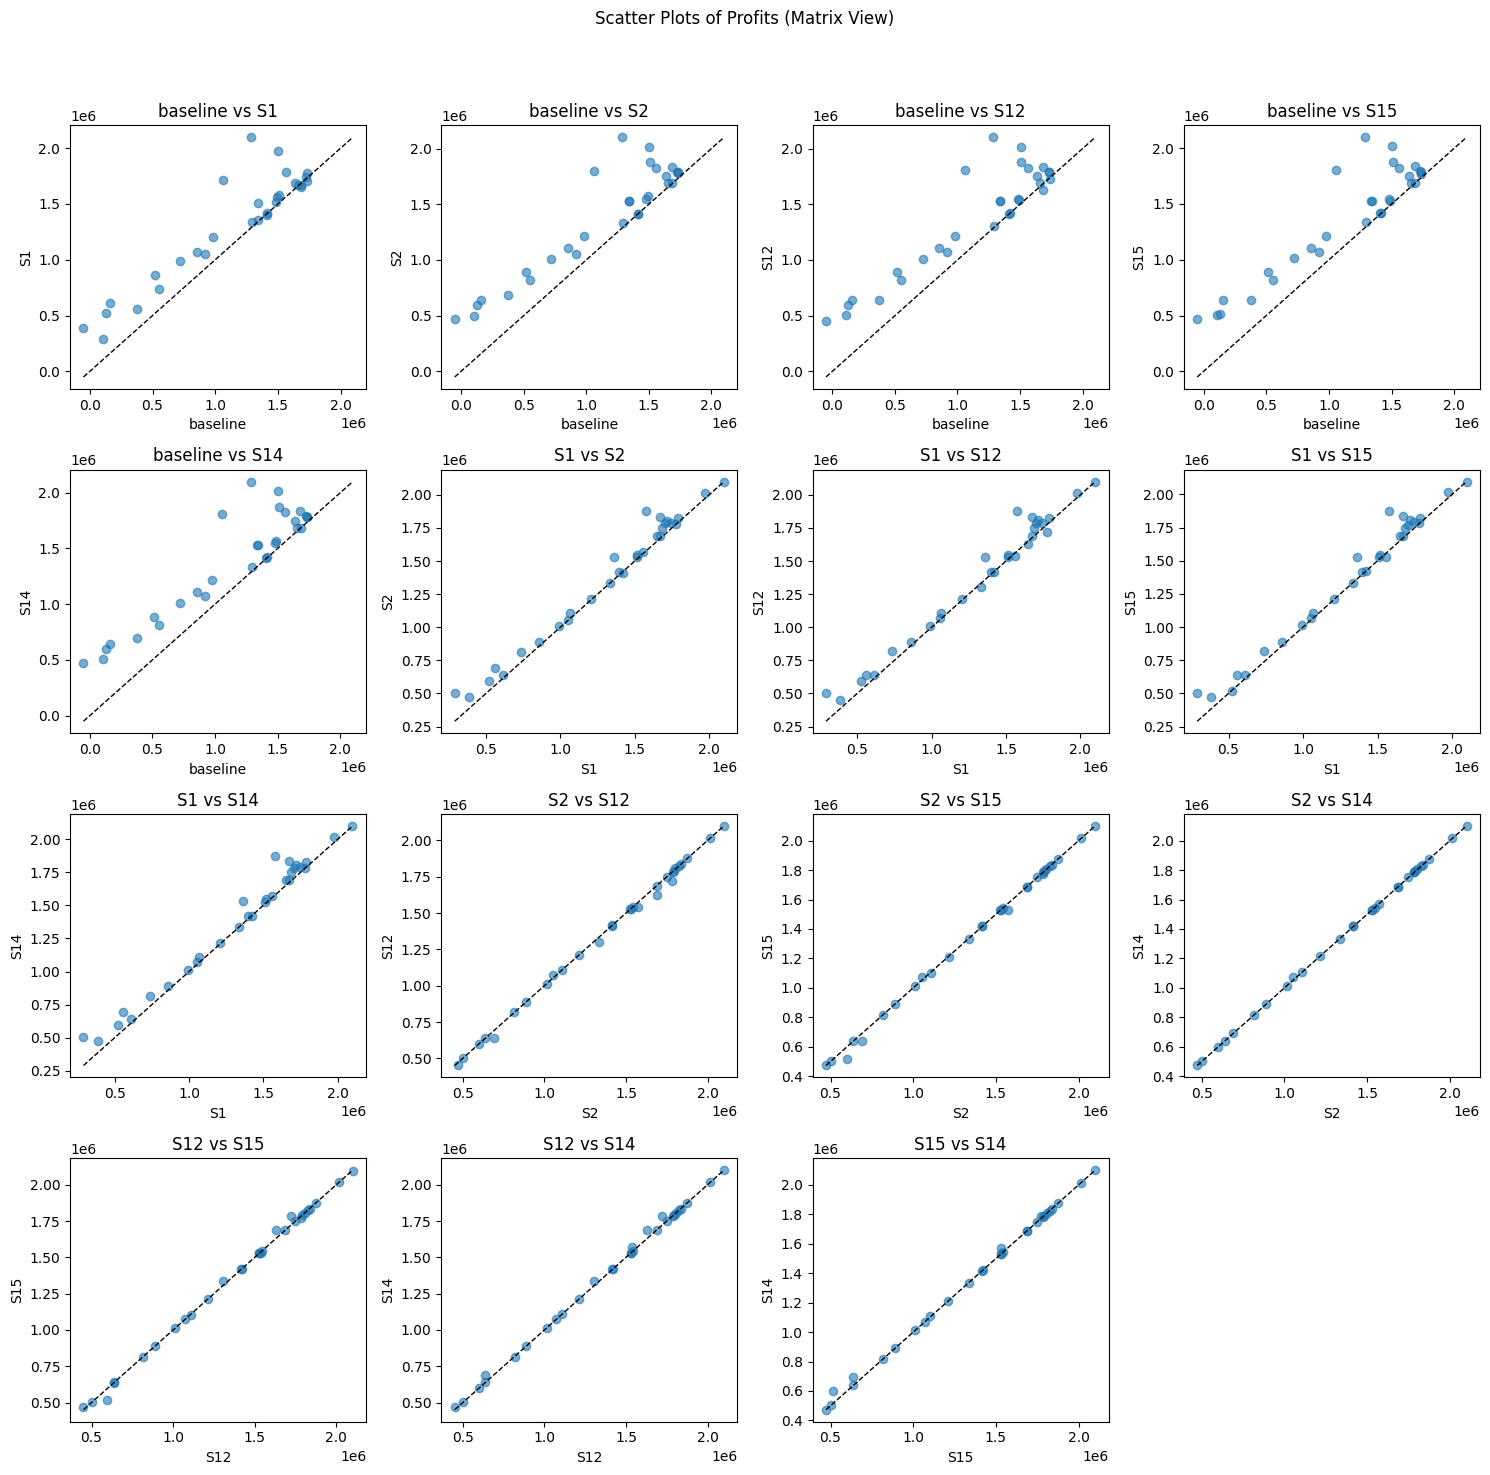

In [113]:
# 訓練階段分佈

baseline_data = []
S1_data = []
S2_data = []
S12_data = []
S14_data = []
S15_data = []

for result in train_all_fold_stimulation_results:
    baseline_data.append(result["baseline"])
    S1_data.append(result["S1"])
    S2_data.append(result["S2"])
    S12_data.append(result["S12"])
    S14_data.append(result["S14"])
    S15_data.append(result["S15"])

# 合併數據
baseline_df = pd.concat(baseline_data, ignore_index=True)
S1_df = pd.concat(S1_data, ignore_index=True)
S2_df = pd.concat(S2_data, ignore_index=True)
S12_df = pd.concat(S12_data, ignore_index=True)
S14_df = pd.concat(S14_data, ignore_index=True)
S15_df = pd.concat(S15_data, ignore_index=True)


dfs = {
    "baseline": baseline_df,
    "S1": S1_df,
    "S2": S2_df,
    "S12": S12_df,
    "S15": S15_df,
    "S14": S14_df,
}

# 調用繪圖函數
plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_0.png


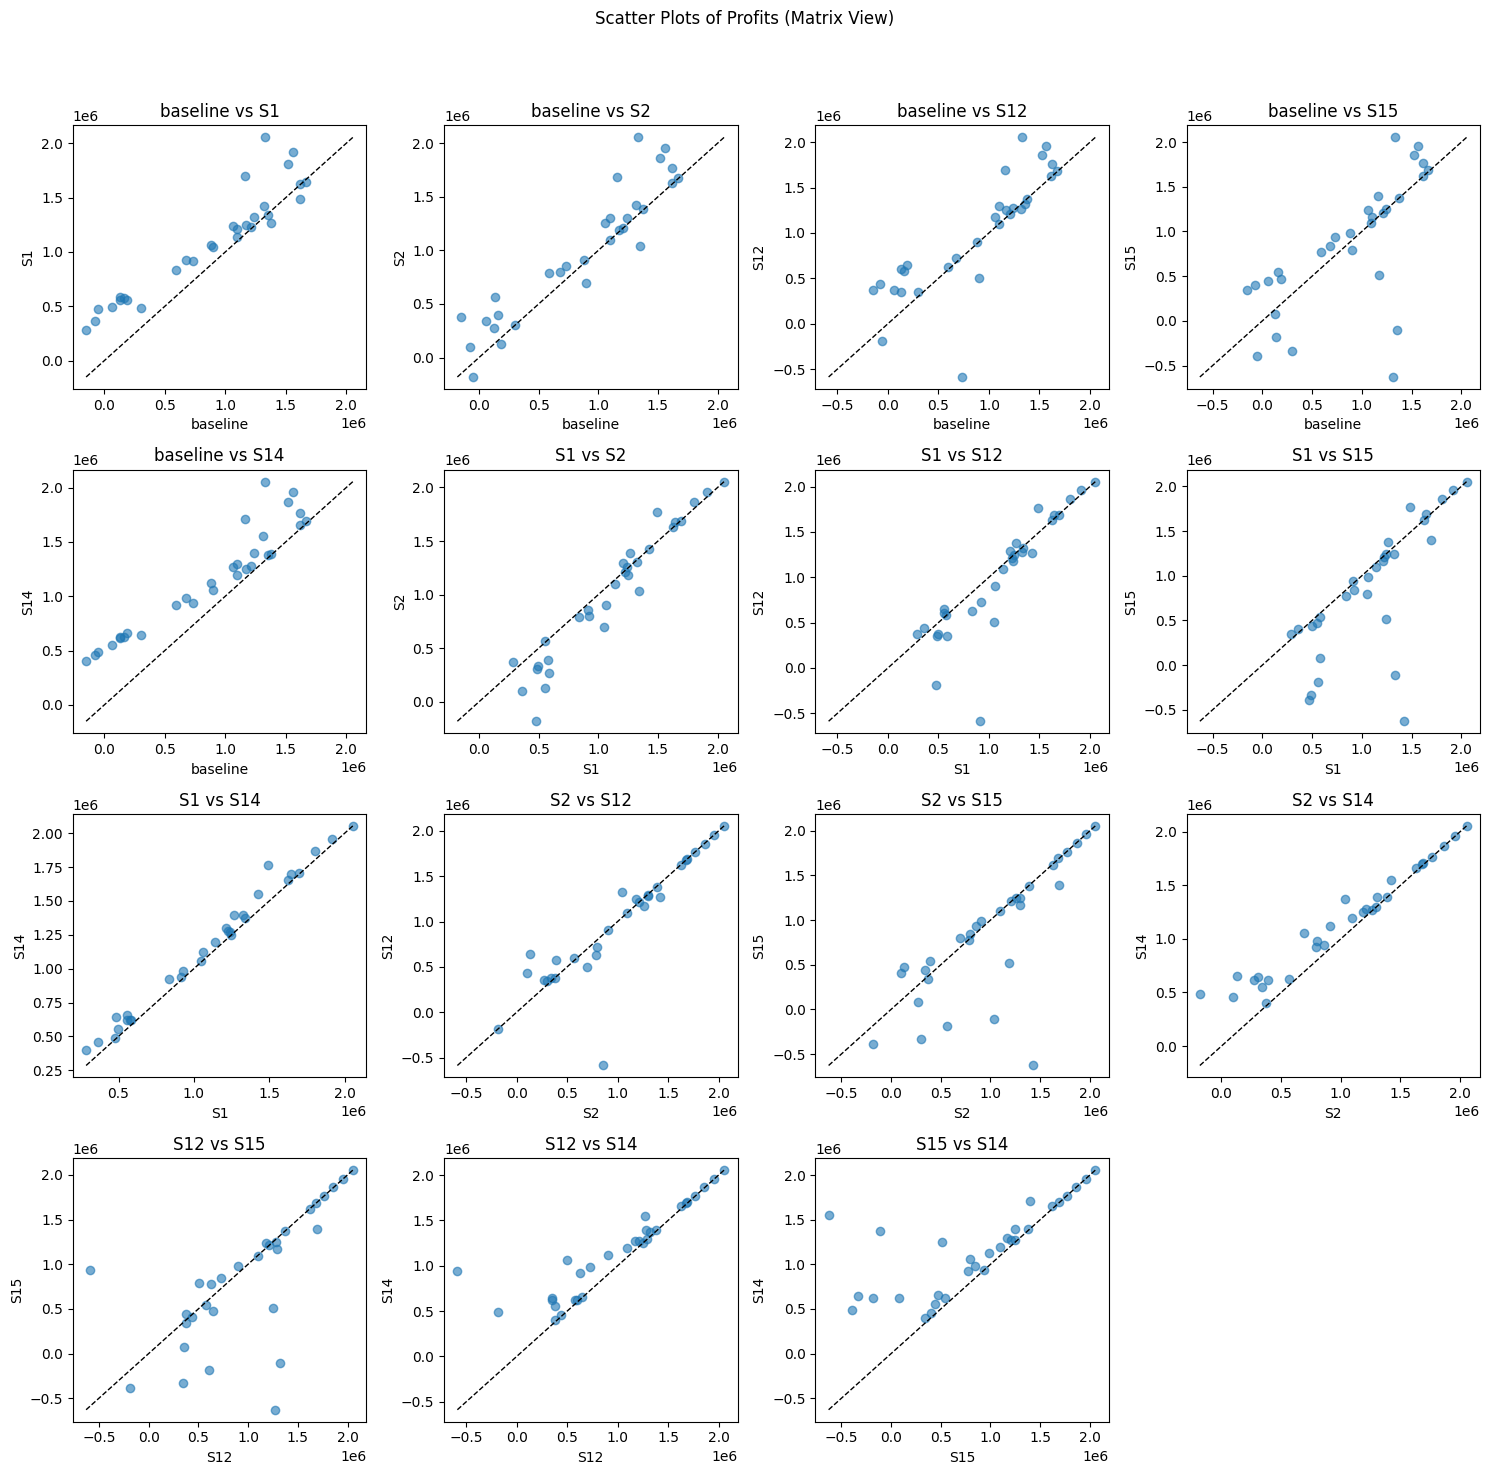

In [114]:
# 測試結果分布圖

baseline_data = []
S1_data = []
S2_data = []
S12_data = []
S14_data = []
S15_data = []

for result in test_all_fold_stimulation_results:
    baseline_data.append(result["baseline"])
    S1_data.append(result["S1"])
    S2_data.append(result["S2"])
    S12_data.append(result["S12"])
    S14_data.append(result["S14"])
    S15_data.append(result["S15"])
# 合併數據
baseline_df = pd.concat(baseline_data, ignore_index=True)
S1_df = pd.concat(S1_data, ignore_index=True)
S2_df = pd.concat(S2_data, ignore_index=True)
S12_df = pd.concat(S12_data, ignore_index=True)
S14_df = pd.concat(S14_data, ignore_index=True)
S15_df = pd.concat(S15_data, ignore_index=True)

dfs = {
    "baseline": baseline_df,
    "S1": S1_df,
    "S2": S2_df,
    "S12": S12_df,
    "S15": S15_df,
    "S14": S14_df,
}

# 調用繪圖函數
plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

In [126]:
import ast

summary_df = pd.read_csv(
    "/Users/hanyuan/Github/Two-Phase-Newsvendor/results/summary.csv"
)

records_str = summary_df.loc[0, "train_df"]
records = ast.literal_eval(records_str)

df_reconstructed = pd.DataFrame(records)
df_reconstructed

,baseline,S1,S2,S12,S15,S14
0,1.176825e+06,1.450204e+06,1.450204e+06,1.449889e+06,1.441655e+06,1.450204e+06
